In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.ticker import FormatStrFormatter
from palettable.cartocolors.qualitative import Bold_10
from palettable.tableau import TrafficLight_9
from scipy.integrate import simpson
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import roc_curve

sns.set_context("notebook", font_scale=1.25)
sns.set_style("ticks")
pd.set_option("display.max_colwidth", 1024)

In [2]:
# axs[5].legend(
#     handles=handles,
#     labels=labels,
#     frameon=False,
#     loc="center",
#     ncol=1,
#     columnspacing=0.5,
#     handletextpad=0.7,
#     handlelength=1.7,
# )

In [3]:
images_dir = "images/"
os.makedirs(images_dir, exist_ok=True)

In [4]:
wd = {
    "TableLlama": "./results/resutablellama.pickle",
    "Gemma-2-2B-it": "./results/resugemma-2-2b-it.pickle",
    "Gemma-2-9B-it": "./results/resugemma-2-9b-it.pickle",
    "Llama-3.1-8B-it": "./results/resullama-3.1-8b-instruct.pickle",
    "Qwen-2.5-7B-it": "./results/resuqwen2.5-7b-instruct.pickle",
}
for k, w in wd.items():
    with open(w, "rb") as handle:
        wd[k] = pickle.load(handle)

In [5]:
wd.keys()

dict_keys(['TableLlama', 'Gemma-2-2B-it', 'Gemma-2-9B-it', 'Llama-3.1-8B-it', 'Qwen-2.5-7B-it'])

In [6]:
wd["TableLlama"].keys()

dict_keys([('generated', 'pe_rao_trans_s_norm'), ('generated', 'answers_entropy_norm'), ('generated_kl', 'answers_entropy_norm'), ('postilla', 'answers_entropy_norm'), ('postilla_reconciled', 'answers_entropy_norm'), ('postilla_kl', 'answers_entropy_norm'), ('postilla_kl_reconciled', 'answers_entropy_norm')])

In [7]:
names_map = {
    "generated_kl": "Generated, LogitLens",
    "generated": "Generated, MaxP + H",
    "postilla_kl_reconciled": "Postilla, LogitLens",
    "postilla_reconciled": "Postilla, MaxP + H",
    "pe_rao_trans_s_norm": "SE",
    "answers_entropy_norm": "PE",
}

In [8]:
import scipy.stats as sps


def random_split(n, m):
    p = sps.dirichlet.rvs(alpha=[1] * m, size=1)
    return 1 + sps.multinomial.rvs(n=n - m, p=p[0], size=1)


random_split(10, 5)

array([[2, 1, 1, 3, 3]])

In [9]:
features_df = {}
for model_name, targets in wd.items():
    if model_name not in features_df:
        features_df[model_name] = {}
    for target_name, (gt, pred, correct_mean_thr, df) in targets.items():
        where, target = target_name
        if "postilla" in where and "reconciled" not in where:
            continue
        df["pred_ent"] = pred
        df["correct_mean_thr"] = df["correct_mean"] >= 0.5
        df["perplexity_l"] = df["perplexity_l"].astype(float)
        index = (names_map[where], names_map[target])
        print(f"Processing {model_name} - {index} - {target_name}")
        df = df.rename(columns={target: index[1], "perplexity_l": "perplexity"})
        if "count" not in df.columns:
            raise ValueError("`count` column not found")
        df["weight"] = df["count"] / 10
        features_df[model_name][index] = df

Processing TableLlama - ('Generated, MaxP + H', 'SE') - ('generated', 'pe_rao_trans_s_norm')
Processing TableLlama - ('Generated, MaxP + H', 'PE') - ('generated', 'answers_entropy_norm')
Processing TableLlama - ('Generated, LogitLens', 'PE') - ('generated_kl', 'answers_entropy_norm')
Processing TableLlama - ('Postilla, MaxP + H', 'PE') - ('postilla_reconciled', 'answers_entropy_norm')
Processing TableLlama - ('Postilla, LogitLens', 'PE') - ('postilla_kl_reconciled', 'answers_entropy_norm')
Processing Gemma-2-2B-it - ('Generated, MaxP + H', 'SE') - ('generated', 'pe_rao_trans_s_norm')
Processing Gemma-2-2B-it - ('Generated, MaxP + H', 'PE') - ('generated', 'answers_entropy_norm')
Processing Gemma-2-2B-it - ('Generated, LogitLens', 'PE') - ('generated_kl', 'answers_entropy_norm')
Processing Gemma-2-2B-it - ('Postilla, MaxP + H', 'PE') - ('postilla_reconciled', 'answers_entropy_norm')
Processing Gemma-2-2B-it - ('Postilla, LogitLens', 'PE') - ('postilla_kl_reconciled', 'answers_entropy_no

In [10]:
features_df.keys()

dict_keys(['TableLlama', 'Gemma-2-2B-it', 'Gemma-2-9B-it', 'Llama-3.1-8B-it', 'Qwen-2.5-7B-it'])

In [11]:
features_df[model_name].keys()

dict_keys([('Generated, MaxP + H', 'SE'), ('Generated, MaxP + H', 'PE'), ('Generated, LogitLens', 'PE'), ('Postilla, MaxP + H', 'PE'), ('Postilla, LogitLens', 'PE')])

In [12]:
features_df[model_name][("Generated, MaxP + H", "PE")].columns

Index(['run', 'pid', 'true_ent_1', 'true_ent_2', 'true_ent_3', 'true_ent_4',
       'true_ent_5', 'true_ent_6', 'true_ent_7', 'true_ent_8', 'true_ent_9',
       'maxp_1', 'maxp_2', 'maxp_3', 'maxp_4', 'maxp_5', 'maxp_6', 'maxp_7',
       'maxp_8', 'maxp_9', 'correct', 'hallucinated', 'PE', 'correct_mean',
       'perplexity', 'count', 'pred_ent', 'correct_mean_thr', 'weight'],
      dtype='object')

In [13]:
features_df[model_name][("Generated, MaxP + H", "PE")].head()

run  pid  true_ent_1  true_ent_2    true_ent_3    true_ent_4  true_ent_5  \
0     0    0    0.784312    0.000128  4.008661e-05  3.201989e-07    0.000065   
2     2    0    0.784312    0.000068  5.743696e-07  1.062176e-04    1.102915   
6     6    0    0.784312    0.000068  5.743696e-07  1.062176e-04    1.102915   
10    0    1    0.449309    0.000128  1.505828e-03  9.492113e-02    0.000502   
15    5    1    0.000032    0.000224  1.810212e-02  1.552422e-03    0.000003   

      true_ent_6    true_ent_7    true_ent_8  ...    maxp_9  correct  \
0   9.233972e-02  2.546900e-03  3.511805e-07  ...  0.911804     True   
2   1.571322e+00  2.212545e+00  1.156253e+00  ...  0.985479    False   
6   2.204955e-01  4.464945e-05  8.416067e-02  ...  1.000000     True   
10  8.104555e-08  2.266075e-02  2.817574e-08  ...  1.000000     True   
15  4.670981e-02  4.980867e-08  5.713866e-08  ...  1.000000    False   

    hallucinated        PE  correct_mean  perplexity  count  pred_ent  \
0          False  0.325083           0.9    1.397534      8  0.341451   
2           True  0.325083           0.9    1.397534      1  0.579573   
6           True  0.325083           0.9    1.397534      1  0.548629   
10         False  0.325083           0.9    1.876681      9  0.335415   
15          True  0.325083           0.9    2.730555      1  0.309090   

    correct_mean_thr  weight  
0               True     0.8  
2               True     0.1  
6               True     0.1  
10              True     0.9  
15              True     0.1  

[5 rows x 29 columns]

In [14]:
features_df[model_name][("Generated, MaxP + H", "PE")].groupby("pid")["weight"].sum().mean()

1.0

In [15]:
palette = {
    name[1] + f"({name[0]})": Bold_10.mpl_colors[i]
    for i, name in enumerate(features_df["TableLlama"].keys())
}
palette["PE(Generated, PP)"] = Bold_10.mpl_colors[len(palette)]
palette["SE(Generated, PP)"] = Bold_10.mpl_colors[len(palette)]
palette["PE(Generated, MaxP)"] = Bold_10.mpl_colors[len(palette)]
palette["PE(Generated, Token-H)"] = Bold_10.mpl_colors[len(palette)]
palette

{'SE(Generated, MaxP + H)': (0.4980392156862745,
  0.23529411764705882,
  0.5529411764705883),
 'PE(Generated, MaxP + H)': (0.06666666666666667,
  0.6470588235294118,
  0.4745098039215686),
 'PE(Generated, LogitLens)': (0.2235294117647059,
  0.4117647058823529,
  0.6745098039215687),
 'PE(Postilla, MaxP + H)': (0.9490196078431372,
  0.7176470588235294,
  0.00392156862745098),
 'PE(Postilla, LogitLens)': (0.9058823529411765,
  0.24705882352941178,
  0.4549019607843137),
 'PE(Generated, PP)': (0.5019607843137255,
  0.7294117647058823,
  0.35294117647058826),
 'SE(Generated, PP)': (0.9019607843137255,
  0.5137254901960784,
  0.06274509803921569),
 'PE(Generated, MaxP)': (0.0, 0.5254901960784314, 0.5843137254901961),
 'PE(Generated, Token-H)': (0.8117647058823529,
  0.10980392156862745,
  0.5647058823529412)}

Computing correlation between `pred_ent`( Generated, MaxP + H ) and SE
Computing correlation between `pred_ent`( Generated, MaxP + H ) and PE
Computing correlation between `pred_ent`( Generated, LogitLens ) and PE
Computing correlation between `pred_ent`( Postilla, MaxP + H ) and PE
Computing correlation between `pred_ent`( Postilla, LogitLens ) and PE
Computing correlation between `pred_ent`( Generated, MaxP + H ) and SE
Computing correlation between `pred_ent`( Generated, MaxP + H ) and PE
Computing correlation between `pred_ent`( Generated, LogitLens ) and PE
Computing correlation between `pred_ent`( Postilla, MaxP + H ) and PE
Computing correlation between `pred_ent`( Postilla, LogitLens ) and PE
Computing correlation between `pred_ent`( Generated, MaxP + H ) and SE
Computing correlation between `pred_ent`( Generated, MaxP + H ) and PE
Computing correlation between `pred_ent`( Generated, LogitLens ) and PE
Computing correlation between `pred_ent`( Postilla, MaxP + H ) and PE
Comput

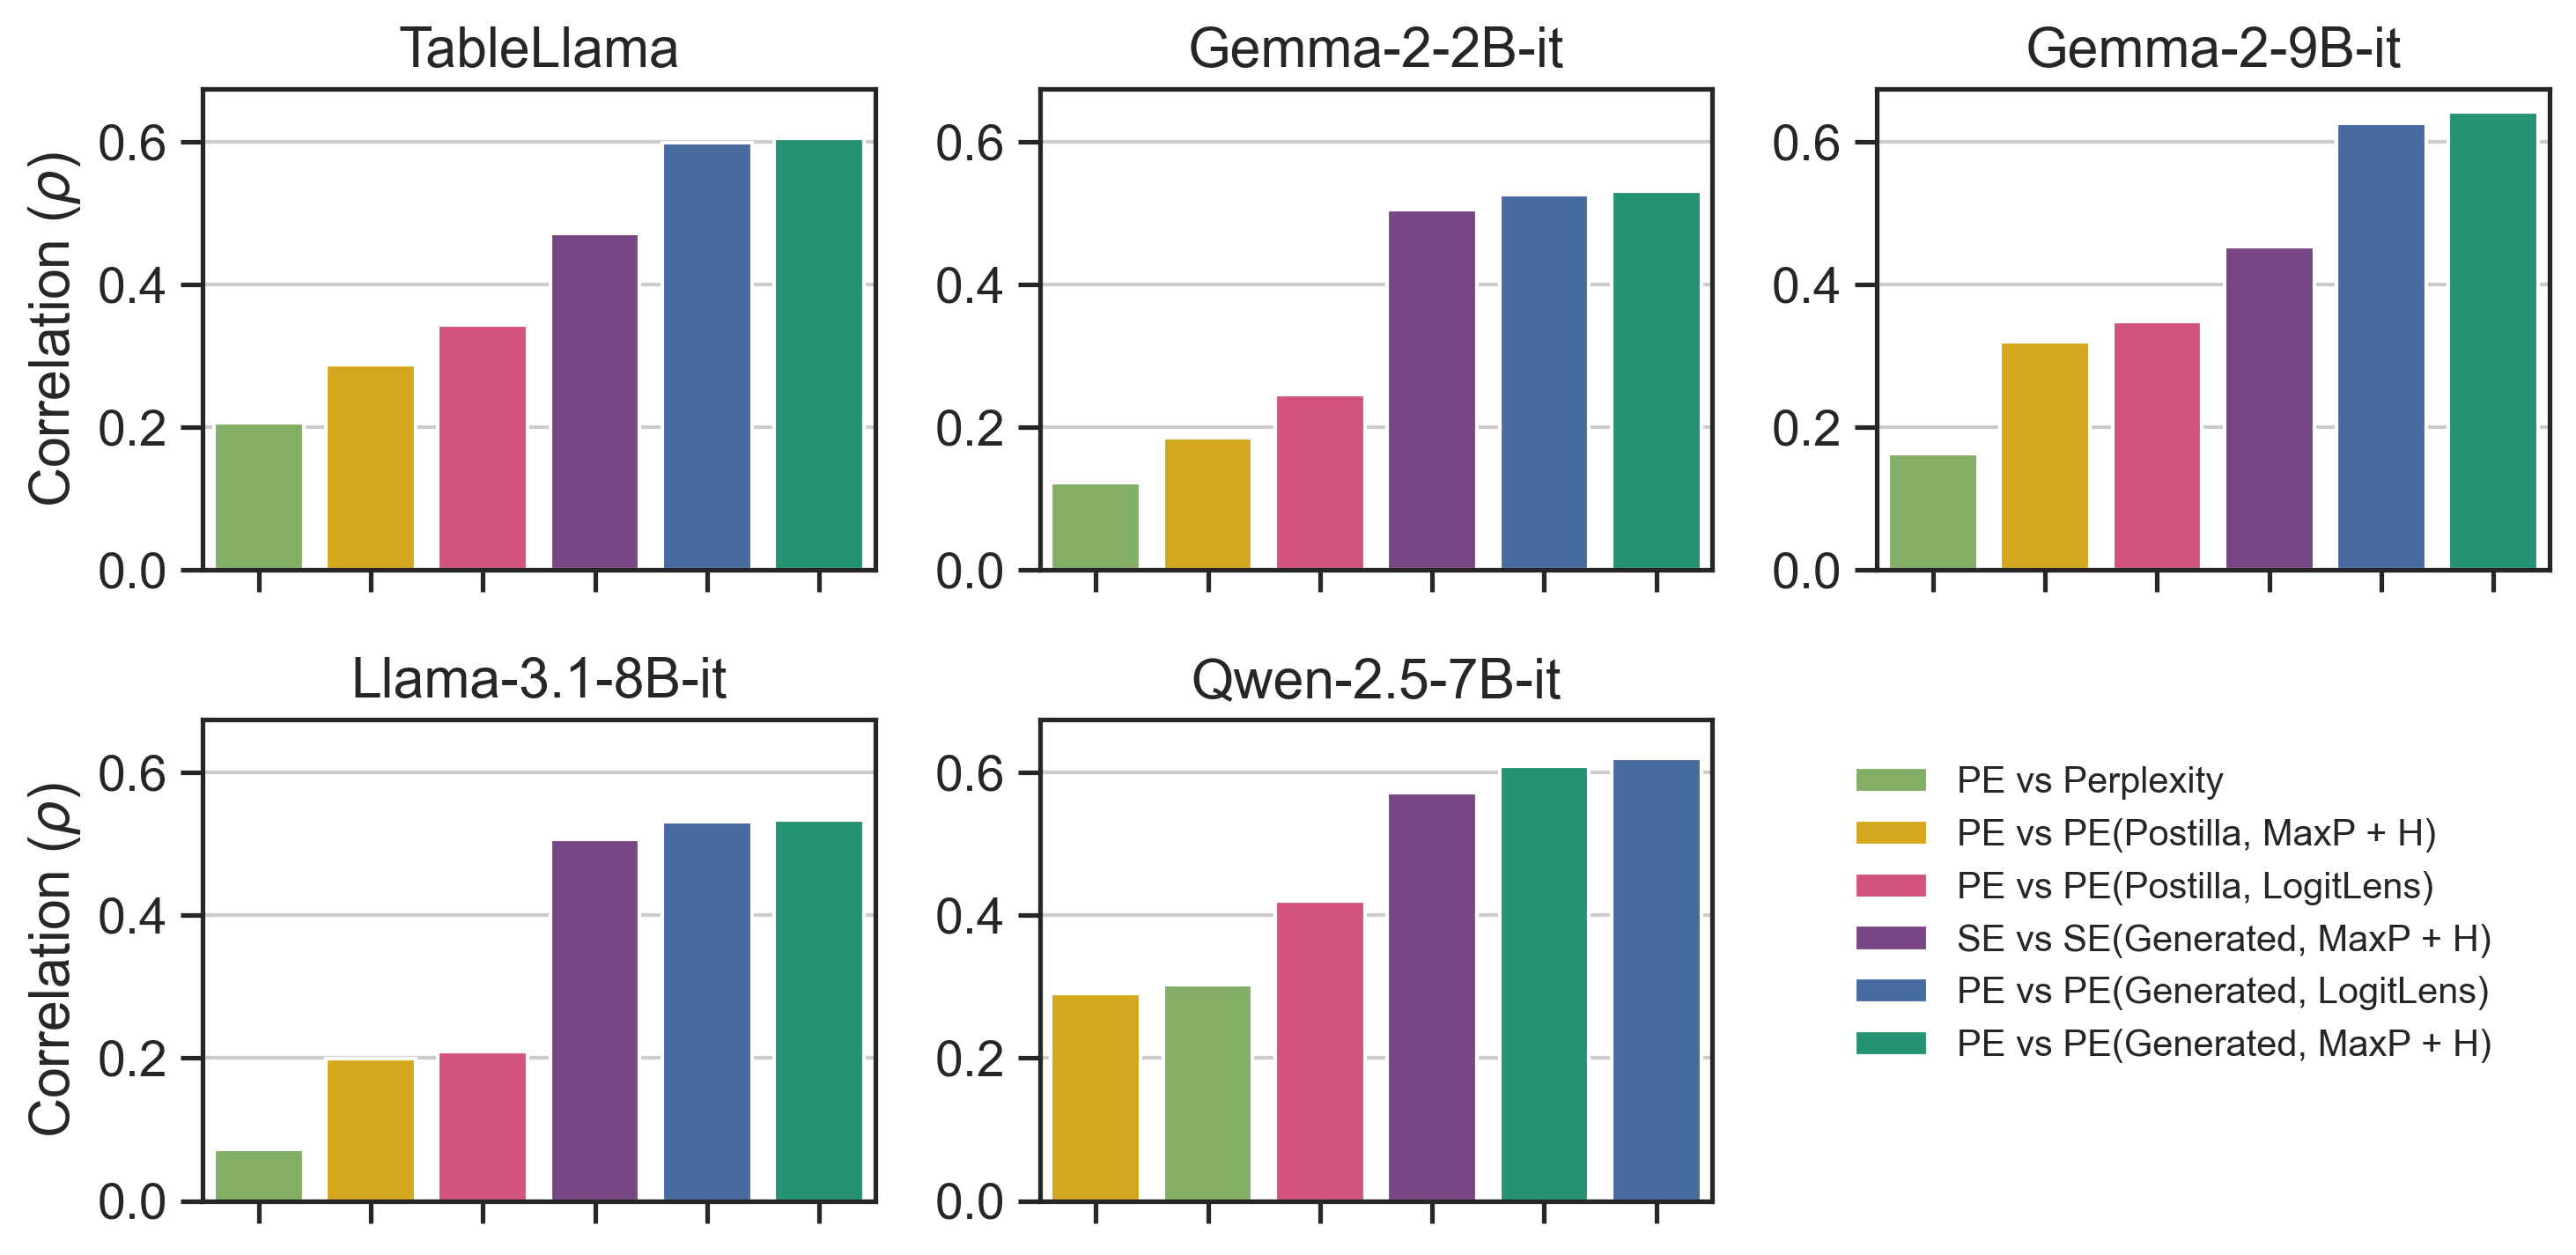

In [17]:
sns.set_context("notebook", font_scale=1.25)
sns.set_style("ticks")


def weighted_pearson_corr(x: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
    """
    Compute weighted Pearson correlation between x and y with weights w.
    """
    # weighted means
    mx = np.average(x, weights=w)
    my = np.average(y, weights=w)
    # weighted covariance & variances
    cov_xy = np.average((x - mx) * (y - my), weights=w)
    var_x = np.average((x - mx) ** 2, weights=w)
    var_y = np.average((y - my) ** 2, weights=w)
    return cov_xy / np.sqrt(var_x * var_y)


def weighted_spearman_corr(x, y, w):
    # Compute ranks (average method for ties)
    Rx = pd.Series(x).rank(method="average").to_numpy()
    Ry = pd.Series(y).rank(method="average").to_numpy()

    # Normalize weights
    w = np.asarray(w)
    W = w.sum()

    # Weighted means of ranks
    mean_Rx = (w * Rx).sum() / W
    mean_Ry = (w * Ry).sum() / W

    # Weighted covariance and variances
    cov = (w * (Rx - mean_Rx) * (Ry - mean_Ry)).sum() / W
    var_x = (w * (Rx - mean_Rx) ** 2).sum() / W
    var_y = (w * (Ry - mean_Ry) ** 2).sum() / W

    return cov / np.sqrt(var_x * var_y)


ncols = 3
nrows = int(np.ceil(len(features_df) / ncols))
fig, axes = plt.subplots(
    figsize=(5 * nrows, 5), nrows=nrows, ncols=ncols, sharex=False, sharey=True, dpi=300
)
axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
# fig.suptitle(
#     "Correlation between Predicted vs True PE",
#     fontsize=17,
#     y=1,
# )

corr_max = 0
corr_function = weighted_spearman_corr
for i, (model_name, targets) in enumerate(features_df.items()):
    corrs = []
    names = []
    ax = axes[i]
    for target_name, df in targets.items():
        print(
            "Computing correlation between `pred_ent`(",
            target_name[0],
            ") and",
            target_name[1],
        )
        corr = corr_function(df["pred_ent"], df[target_name[1]], df["weight"])
        corrs.append(corr)
        names.append(target_name[1] + f"({target_name[0]})")
    # Correlation with perplexity
    df = features_df[model_name][("Generated, MaxP + H", "PE")]
    corr = corr_function(df["perplexity"], df["PE"], df["weight"])
    corrs.append(corr)
    names.append("PE(Generated, PP)")

    df_corrs = pd.DataFrame({"corr": corrs, "name": names})
    corr_max = max(corr_max, df_corrs["corr"].max())
    sns.barplot(
        data=df_corrs.sort_values("corr"),
        x="name",
        y="corr",
        hue="name",
        legend=True if i == 0 else False,
        palette=palette,
        ax=ax,
    )
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend().remove()
    ax.set_xticklabels([], rotation=45, ha="right")
    ax.set_ylabel("Correlation ($\\rho$)")
    ax.set_xlabel("")
    ax.set_title(f"{model_name}")
    ax.set_axisbelow(True)
    ax.grid(True, axis="y")
for h in range(len(axes)):
    # axes[h].set_ylim(0, corr_max + 0.1)
    axes[h].tick_params(axis="y", which="both", labelleft=True)
for j in range(i + 1, len(axes)):
    axes[j].axis("off")
updated_labels = []
for l in labels:
    target_name = l.split("(")[0]
    if "PP" in l:
        updated_labels.append(target_name + " vs Perplexity")
    elif "PE(Generated, MaxP)" == l:
        updated_labels.append(target_name + " vs Avg. MaxP")
    elif "PE(Generated, Token-H)" == l:
        updated_labels.append(target_name + " vs Avg. Token Entropy")
    else:
        updated_labels.append(target_name + " vs " + l)
fig.legend(
    handles,
    updated_labels,
    loc="upper center",
    bbox_to_anchor=(0.835, 0.42),
    ncol=1,
    title_fontsize=12,
    fontsize=10,
    title="",
    frameon=False,
)
plt.tight_layout()
plt.savefig(
    os.path.join(images_dir, "predicted_vs_true_PE_correlation.png"),
    bbox_inches="tight",
    dpi=300,
)

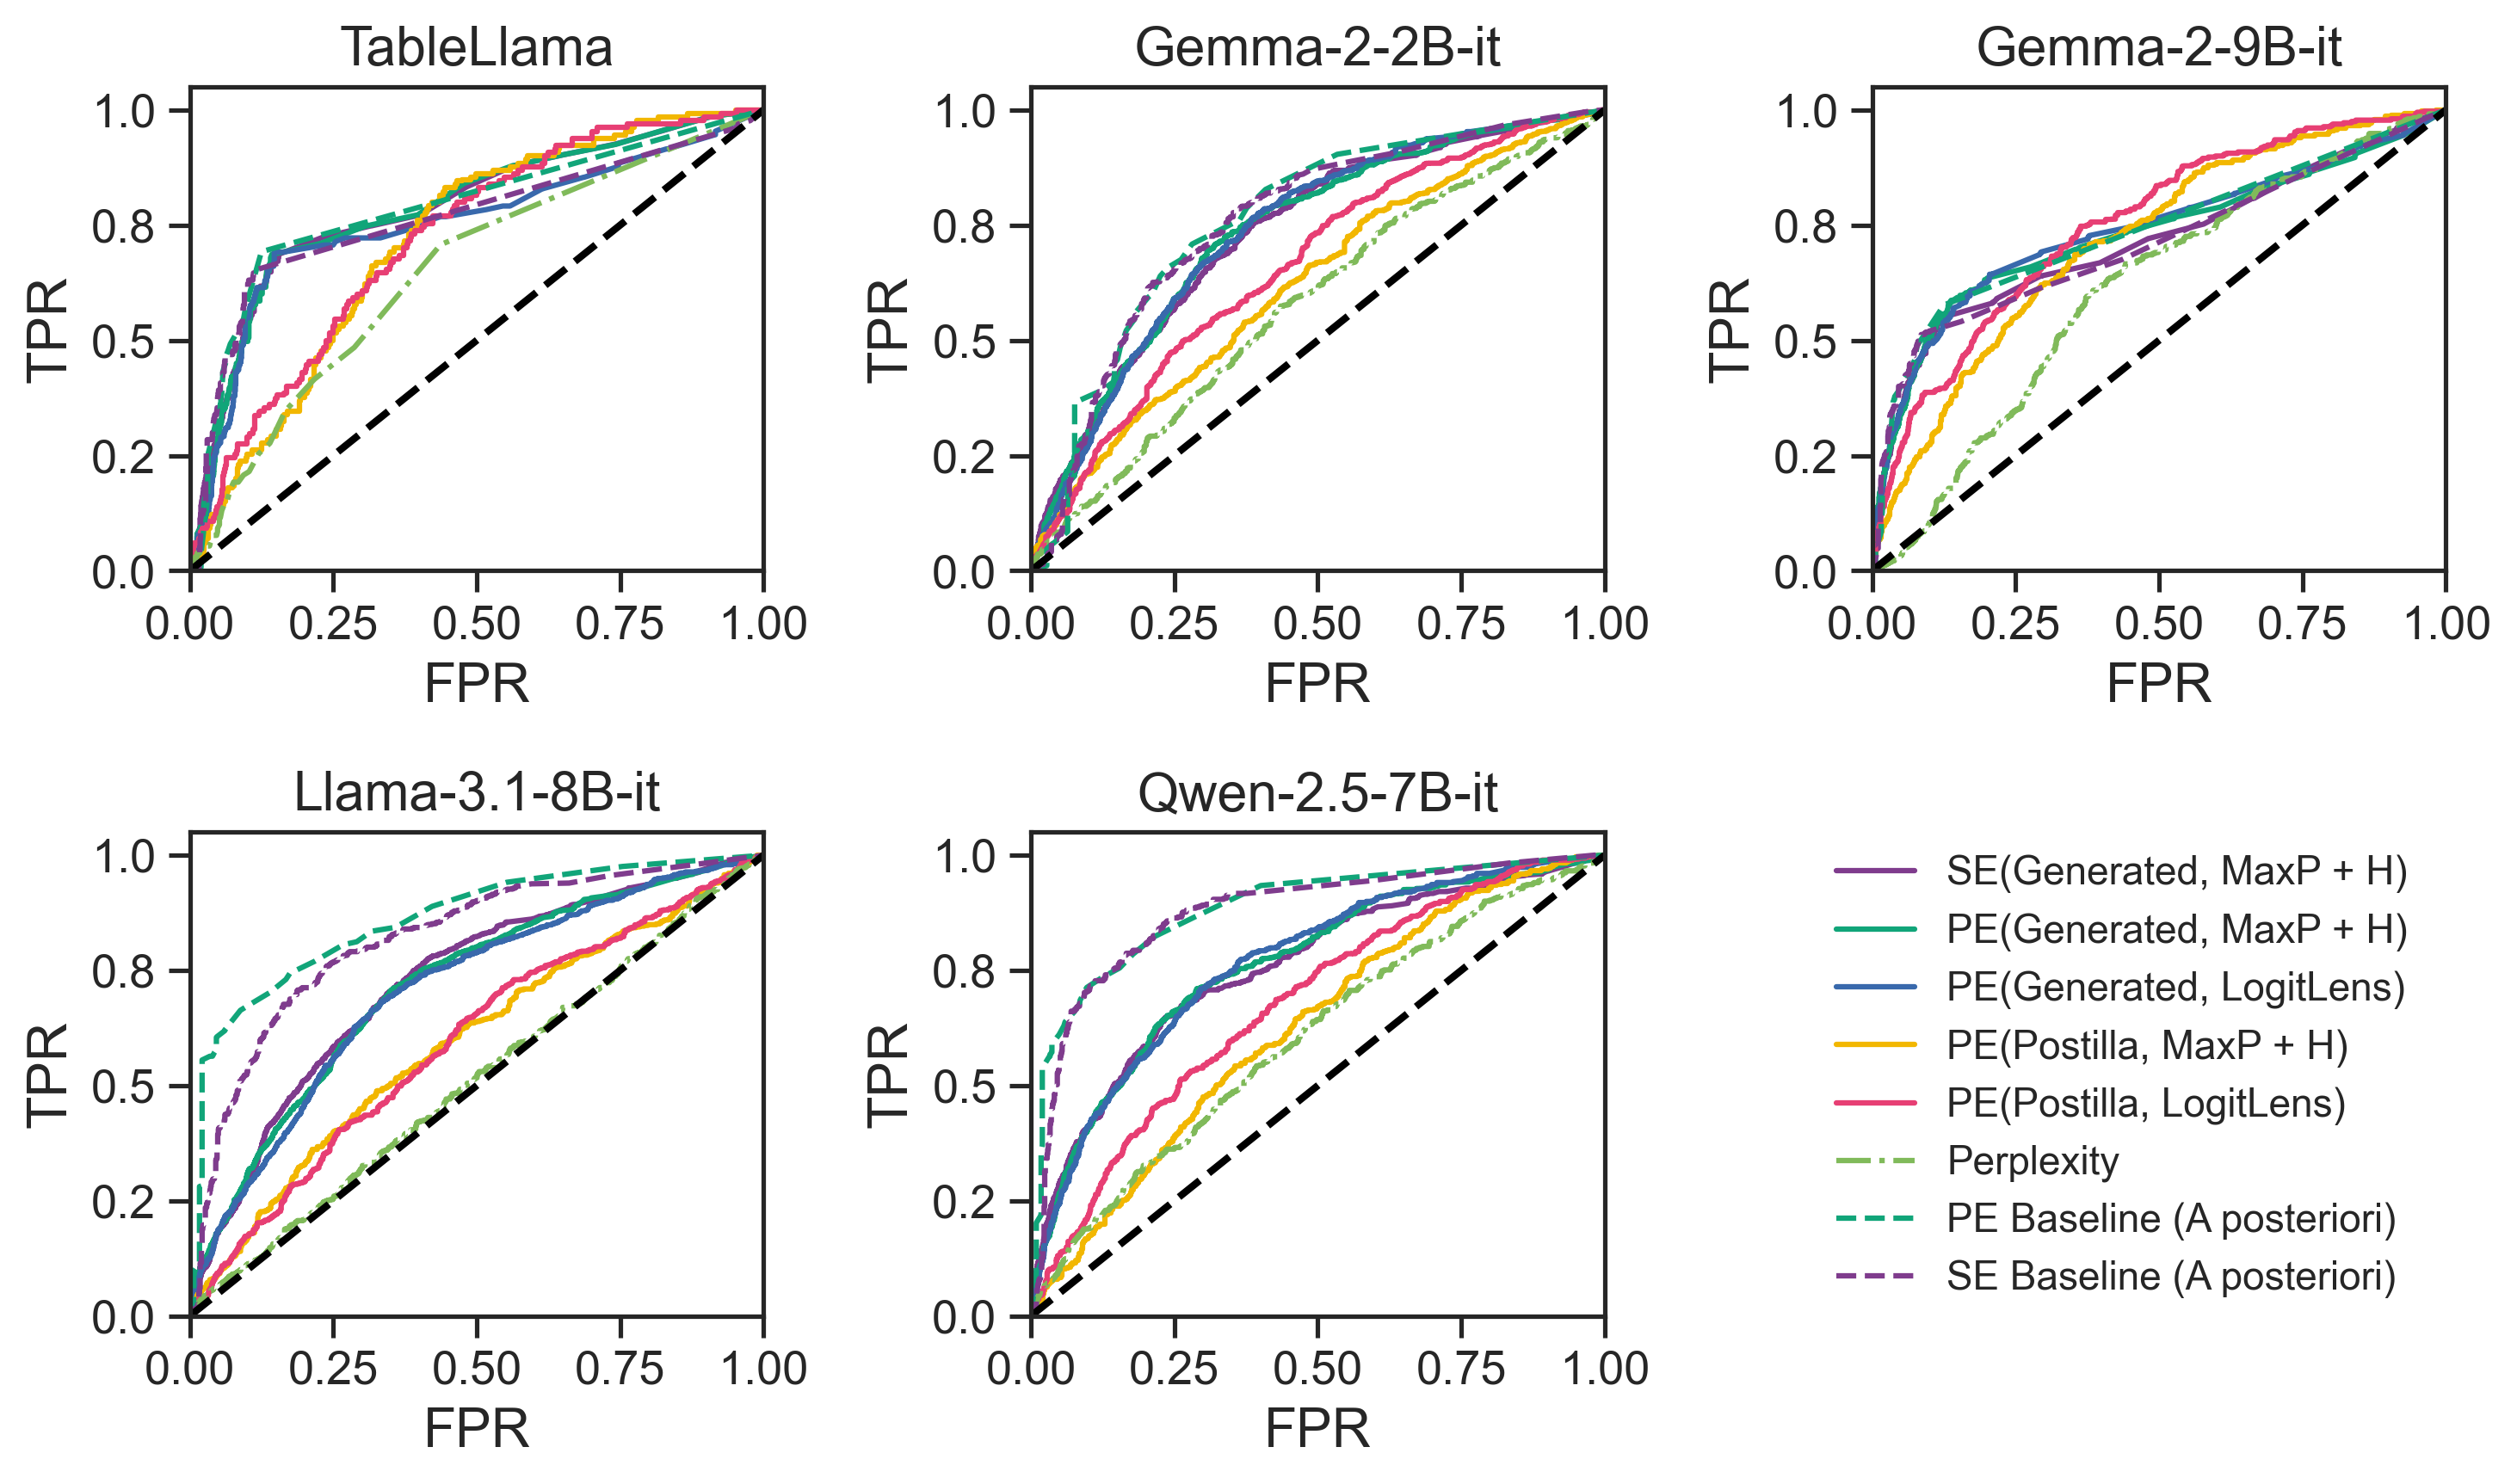

In [18]:
ncols = 3
nrows = int(np.ceil(len(features_df) / ncols))
fig, axes = plt.subplots(
    figsize=(5 * nrows, 6),
    nrows=nrows,
    ncols=ncols,
    sharex=False,
    sharey=False,
    dpi=300,
)
# fig.suptitle(
#     "ROC Curves for the different models and targets",
#     fontsize=17,
#     y=1.0,
# )
axes = axes.flatten() if isinstance(axes, np.ndarray) else np.array([axes])

legend = None
for i, (model_name, targets) in enumerate(features_df.items()):
    ax = axes[i]
    for j, (target_name, df) in enumerate(targets.items()):
        fpr, tpr, _ = roc_curve(
            1 - df["correct_mean_thr"], df["pred_ent"], sample_weight=df["weight"]
        )
        ax.plot(
            fpr,
            tpr,
            label=f"{target_name[1]}({target_name[0]})",
            color=palette[f"{target_name[1]}({target_name[0]})"],
        )
    # Perplexity ROC
    fpr, tpr, _ = roc_curve(
        1 - df["correct_mean_thr"], df["perplexity"], sample_weight=df["weight"]
    )
    ax.plot(
        fpr,
        tpr,
        label=f"{target_name[1]}(Generated, PP)",
        color=palette[f"{target_name[1]}(Generated, PP)"],
        linestyle="-.",
    )
    # Entropy ROC
    df = targets[("Generated, MaxP + H", "PE")]
    fpr, tpr, _ = roc_curve(
        1 - df["correct_mean_thr"], df["PE"], sample_weight=df["weight"]
    )
    ax.plot(
        fpr,
        tpr,
        label=f"PE Baseline",
        color=palette["PE(Generated, MaxP + H)"],
        linestyle="--",
    )
    # SE ROC
    df = targets[("Generated, MaxP + H", "SE")]
    fpr, tpr, _ = roc_curve(
        1 - df["correct_mean_thr"], df["SE"], sample_weight=df["weight"]
    )
    ax.plot(
        fpr,
        tpr,
        label=f"SE Baseline",
        color=palette["SE(Generated, MaxP + H)"],
        linestyle="--",
    )
    ax.plot([0, 1], [0, 1], "k--", lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title(model_name)
    ax.set_xticks(
        np.arange(0, 1.1, 0.25),
        labels=[f"{x:.2f}" for x in np.arange(0, 1.1, 0.25)],
        fontsize=13,
    )
    ax.set_yticks(
        np.arange(0, 1.1, 0.25),
        labels=[f"{x:.1f}" for x in np.arange(0, 1.1, 0.25)],
        fontsize=13,
    )
    if legend is None:
        legend = ax.legend()
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

updated_labels = []
for l in labels:
    if "PP" in l:
        updated_labels.append("Perplexity")
    elif "Baseline" in l:
        if "MaxP" not in l and "Token-Entropy" not in l:
            updated_labels.append(l + " (A posteriori)")
        else:
            updated_labels.append(l)
    else:
        updated_labels.append(l)
fig.legend(
    handles,
    updated_labels,
    loc="upper left",
    bbox_to_anchor=(0.71, 0.45),
    ncol=1,
    fontsize=11,
    frameon=False,
)
plt.tight_layout()
plt.savefig(
    os.path.join(images_dir, "roc_curves.png"),
    bbox_inches="tight",
    dpi=300,
)

Model TableLlama with target ('Generated, MaxP + H', 'PE')
Bootstrapping Generated, MaxP + H
Bootstrapping PE
Bootstrapping Perplexity
Bootstrapping Oracle
Model Gemma-2-2B-it with target ('Generated, MaxP + H', 'PE')
Bootstrapping Generated, MaxP + H
Bootstrapping PE
Bootstrapping Perplexity
Bootstrapping Oracle
Model Gemma-2-9B-it with target ('Generated, MaxP + H', 'PE')
Bootstrapping Generated, MaxP + H
Bootstrapping PE
Bootstrapping Perplexity
Bootstrapping Oracle
Model Llama-3.1-8B-it with target ('Generated, MaxP + H', 'PE')
Bootstrapping Generated, MaxP + H
Bootstrapping PE
Bootstrapping Perplexity
Bootstrapping Oracle
Model Qwen-2.5-7B-it with target ('Generated, MaxP + H', 'PE')
Bootstrapping Generated, MaxP + H
Bootstrapping PE
Bootstrapping Perplexity
Bootstrapping Oracle


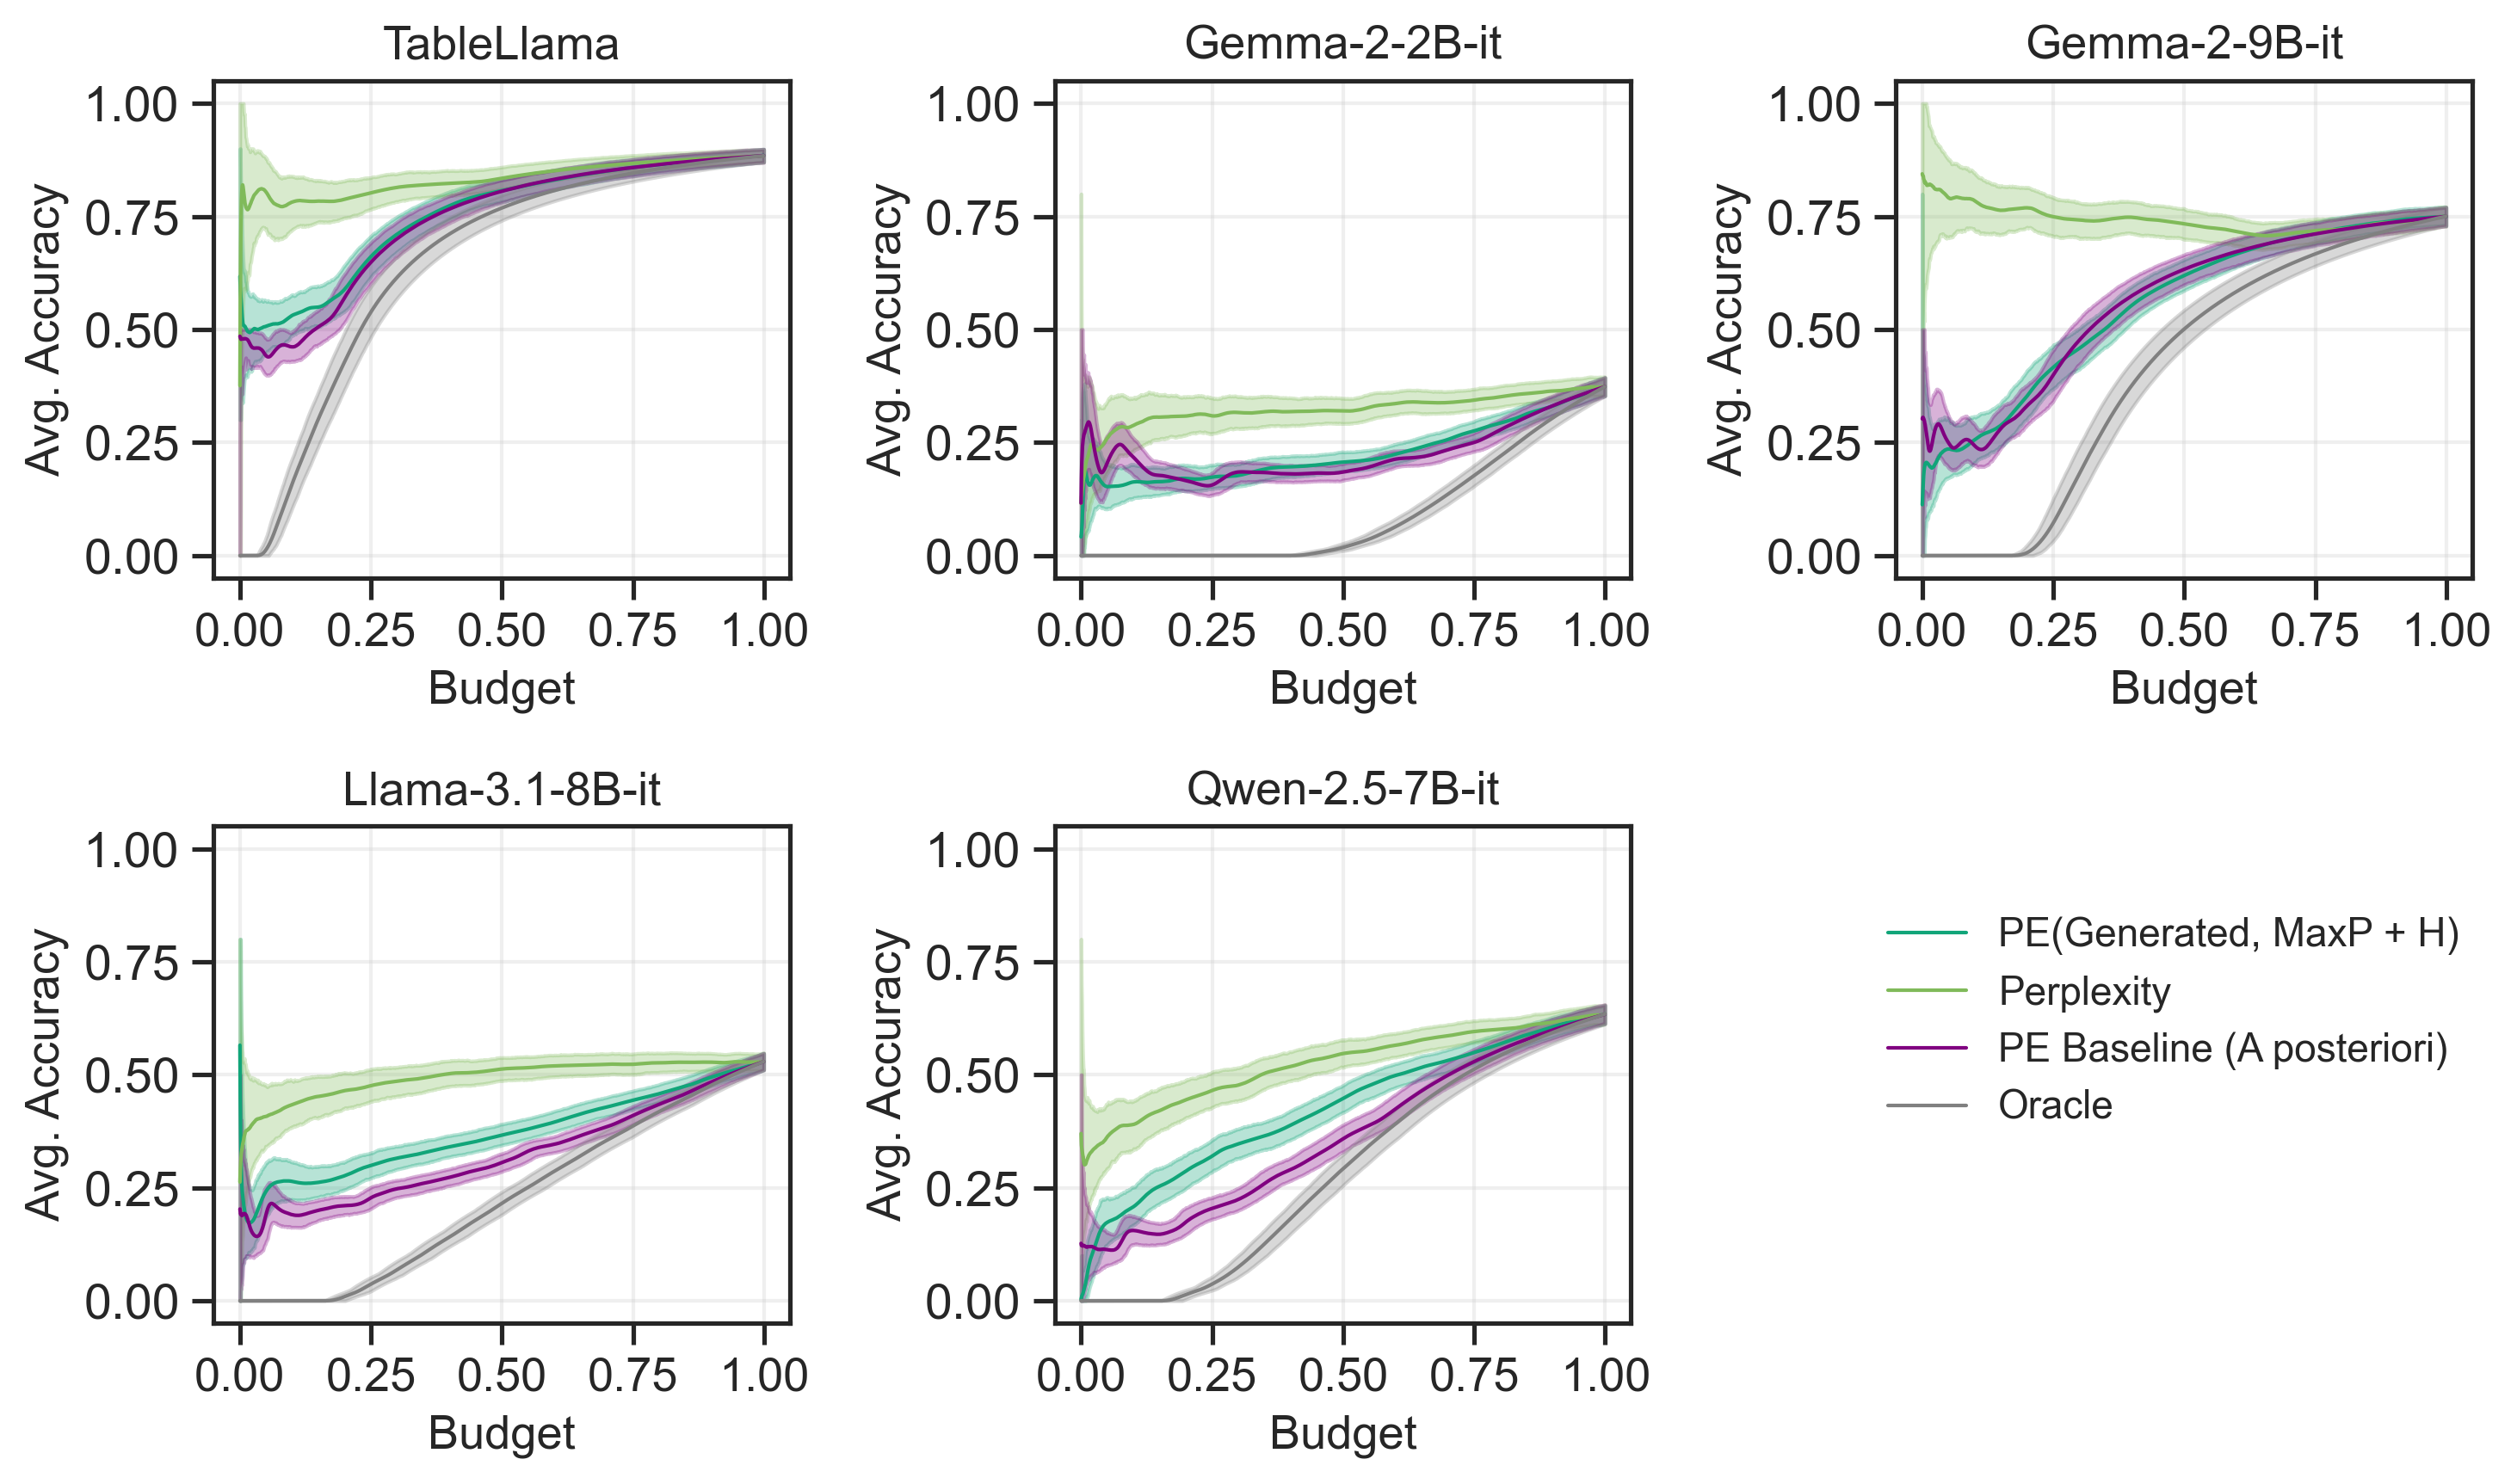

In [20]:
def prepare_pid_stats(
    df,
    pid_col="pid",
    weight_col="weight",
    target_col="Entropy",
    pred_col="pred_ent",
):
    """
    From the raw runs df, build a dict mapping each pid to:
      - N: number of runs
      - p: normalized weight vector (sum=1)
      - x_pred, x_true, x_acc: NumPy arrays of pred_ent, Entropy, correct_mean
    """
    pid_groups = {}
    for pid, g in df.groupby(pid_col):
        p = g[weight_col].to_numpy()
        N = len(p)
        pid_groups[pid] = {
            "N": N,
            "p": p,
            "x_pred": (
                1 - g[pred_col].to_numpy()
                if "correct_mean" in pred_col
                else g[pred_col].to_numpy()
            ),
            "x_true": (
                1 - g[target_col].to_numpy()
                if "correct_mean" in target_col
                else g[target_col].to_numpy()
            ),
            "x_acc": g["correct_mean"].to_numpy(),
        }
    return pid_groups


def summarize(curves):
    return (
        curves.mean(axis=0),
        np.percentile(curves, 2.5, axis=0),
        np.percentile(curves, 97.5, axis=0),
    )


def bootstrap_two_level(
    pid_groups: dict,
    n_prompts: int,
    n_bootstraps: int = 1000,
    n_bootstrap_samples: int = 10,
    sort_by: str = "pred",  # "pred" or "true"
):
    """
    Performs two-level bootstrap:
      A) sample pids with replacement (size=n_prompts)
      B) for each sampled pid, draw multinomial counts for its runs
         according to the pid's weight-distribution
      C) compute weighted mean per-pid for pred_ent / true_ent / acc
      D) sort by the chosen target and build mean of acc
    Returns array shape (n_bootstraps, n_prompts).
    """
    pid_list = list(pid_groups.keys())
    curves = np.zeros((n_bootstraps, n_prompts))

    for b in range(n_bootstraps):
        # A) sample pids
        sampled = np.random.choice(pid_list, size=n_prompts, replace=True)
        means_target = np.empty(n_prompts)
        means_acc = np.empty(n_prompts)

        # B+C) multinomial sampling + weighted means
        for i, pid in enumerate(sampled):
            rec = pid_groups[pid]
            c = np.random.multinomial(n_bootstrap_samples, rec["p"])
            means_target[i] = np.dot(c, rec[f"x_{sort_by}"]) / n_bootstrap_samples
            means_acc[i] = np.dot(c, rec["x_acc"]) / n_bootstrap_samples

        # D) sort by target & mean of accuracy
        order = np.argsort(-means_target)
        sorted_acc = means_acc[order]
        curves[b] = np.cumsum(sorted_acc) / np.arange(1, n_prompts + 1)
    return curves


ncols = 3
nrows = int(np.ceil(len(features_df) / ncols))
fig, axes = plt.subplots(
    figsize=(5 * nrows, 6),
    nrows=nrows,
    ncols=ncols,
    sharex=False,
    sharey=True,
    dpi=300,
)
# fig.suptitle(f"Avg. Accuracy vs Entropy-Ranked Prompts", fontsize=17)
axes = axes.flatten() if isinstance(axes, np.ndarray) else np.array([axes])

n_bootstraps = 1000
for i, model_name in enumerate(features_df):
    ax = axes[i]
    target = ("Generated, MaxP + H", "PE")
    print(f"Model {model_name} with target {target}")
    df = features_df[model_name][target]

    pid_groups = prepare_pid_stats(
        df,
        pid_col="pid",
        weight_col="weight",
        target_col=target[1],
        pred_col="pred_ent",
    )
    n_prompts = len(pid_groups)

    print(f"Bootstrapping {target[0]}")
    boot = bootstrap_two_level(
        pid_groups, n_prompts, n_bootstraps=n_bootstraps, sort_by="pred"
    )
    m_pred, l_pred, u_pred = summarize(boot)
    x = 100 * np.arange(n_prompts) / n_prompts

    print(f"Bootstrapping {target[1]}")
    boot = bootstrap_two_level(
        pid_groups, n_prompts, n_bootstraps=n_bootstraps, sort_by="true"
    )
    m_true, l_true, u_true = summarize(boot)
    x = 100 * np.arange(n_prompts) / n_prompts

    print(f"Bootstrapping Perplexity")
    pid_groups = prepare_pid_stats(
        df,
        pid_col="pid",
        weight_col="weight",
        target_col=target[1],
        pred_col="perplexity",
    )
    n_prompts = len(pid_groups)
    boot = bootstrap_two_level(
        pid_groups, n_prompts, n_bootstraps=n_bootstraps, sort_by="pred"
    )
    m_pp, l_pp, u_pp = summarize(boot)
    x = 100 * np.arange(n_prompts) / n_prompts

    ax.plot(
        x,
        m_pred,
        label=f"{target[1]}({target[0]})",
        lw=1,
        color=palette[f"{target[1]}({target[0]})"],
    )
    ax.fill_between(
        x,
        l_pred,
        u_pred,
        alpha=0.3,
        color=palette[f"{target[1]}({target[0]})"],
    )

    ax.plot(
        x,
        m_pp,
        label=f"{target[1]}(Generated, PP)",
        lw=1,
        color=palette["PE(Generated, PP)"],
    )
    ax.fill_between(
        x,
        l_pp,
        u_pp,
        alpha=0.3,
        color=palette["PE(Generated, PP)"],
    )
    ax.plot(
        x,
        m_true,
        label=f"{target[1]} Baseline",
        lw=1,
        color="purple",
    )
    ax.fill_between(
        x,
        l_true,
        u_true,
        alpha=0.3,
        color="purple",
    )

    print("Bootstrapping Oracle")
    pid_groups = prepare_pid_stats(
        df,
        pid_col="pid",
        weight_col="weight",
        target_col="correct_mean",
        pred_col="correct_mean",
    )
    n_prompts = len(pid_groups)
    boot = bootstrap_two_level(
        pid_groups, n_prompts, n_bootstraps=n_bootstraps, sort_by="pred"
    )
    m_pred, l_pred, u_pred = summarize(boot)
    x = 100 * np.arange(n_prompts) / n_prompts

    ax.plot(
        x,
        m_pred,
        label=f"Oracle",
        lw=1,
        color="grey",
    )
    ax.fill_between(
        x,
        l_pred,
        u_pred,
        alpha=0.3,
        color="grey",
    )

    if i == 0:
        ax.legend(fontsize=11, title="", ncol=3)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend().remove()
    ax.set_xlabel("Budget", fontsize=13)
    ax.set_xticks(
        np.arange(0, 101, 25),
        labels=[f"{x / 100:.2f}" for x in np.arange(0, 101, 25)],
        fontsize=13,
    )
    ax.set_ylabel("Avg. Accuracy", fontsize=13)
    ax.set_title(f"{model_name}", fontsize=13)
    ax.grid(alpha=0.3)
    ax.tick_params(axis="y", which="both", labelleft=True)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

# Legend to the right of the last plot
updated_labels = []
for l in labels:
    if "PP" in l:
        updated_labels.append("Perplexity")
    elif "Baseline" in l:
        if "MaxP" not in l and "Token-Entropy" not in l:
            updated_labels.append(l + " (A posteriori)")
        else:
            updated_labels.append(l)
    else:
        updated_labels.append(l)
fig.legend(
    handles,
    updated_labels,
    loc="upper left",
    bbox_to_anchor=(0.73, 0.41),
    ncol=1,
    fontsize=11,
    frameon=False,
)
plt.tight_layout()
plt.savefig(
    os.path.join(images_dir, "bootstrapped_cumulative_accuracy_per_model.png"),
    bbox_inches="tight",
    dpi=300,
)

### Bootstrap All-features vs True - Per model

Bootstrapping Generated, MaxP + H
Bootstrapping SE
Bootstrapping Oracle
Bootstrapping PE
Bootstrapping Generated, LogitLens
Bootstrapping Postilla, MaxP + H
Bootstrapping Postilla, LogitLens
Bootstrapping Generated, MaxP + H
Bootstrapping SE
Bootstrapping Oracle
Bootstrapping PE
Bootstrapping Generated, LogitLens
Bootstrapping Postilla, MaxP + H
Bootstrapping Postilla, LogitLens
Bootstrapping Generated, MaxP + H
Bootstrapping SE
Bootstrapping Oracle
Bootstrapping PE
Bootstrapping Generated, LogitLens
Bootstrapping Postilla, MaxP + H
Bootstrapping Postilla, LogitLens
Bootstrapping Generated, MaxP + H
Bootstrapping SE
Bootstrapping Oracle
Bootstrapping PE
Bootstrapping Generated, LogitLens
Bootstrapping Postilla, MaxP + H
Bootstrapping Postilla, LogitLens
Bootstrapping Generated, MaxP + H
Bootstrapping SE
Bootstrapping Oracle
Bootstrapping PE
Bootstrapping Generated, LogitLens
Bootstrapping Postilla, MaxP + H
Bootstrapping Postilla, LogitLens


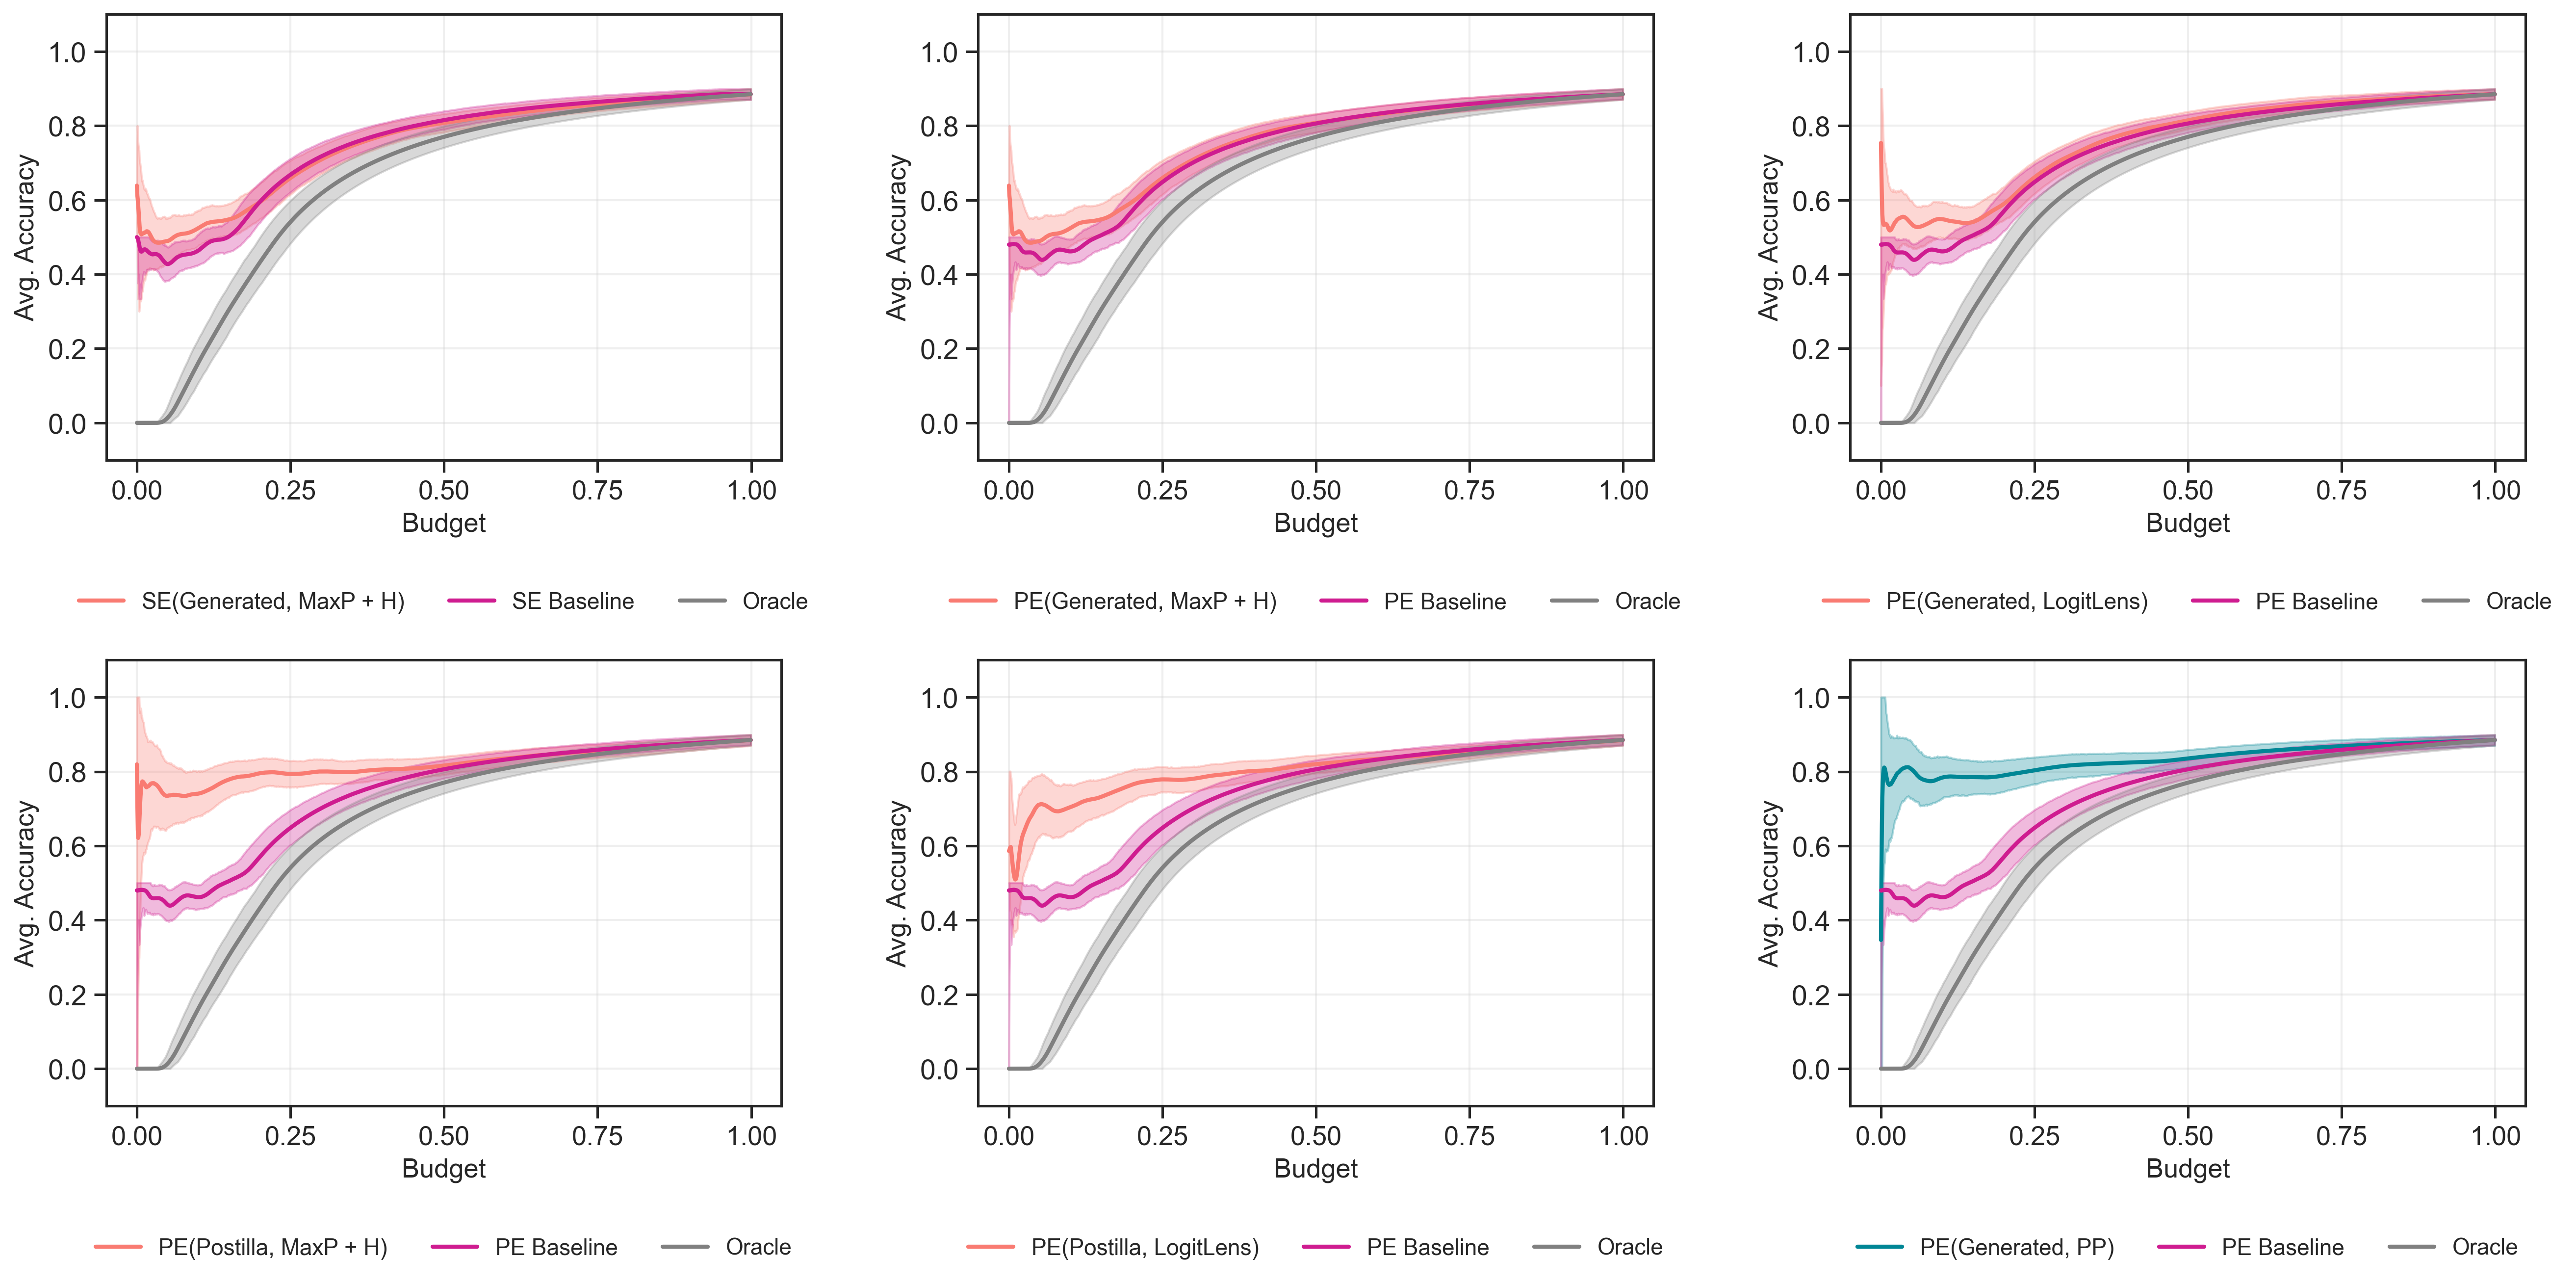

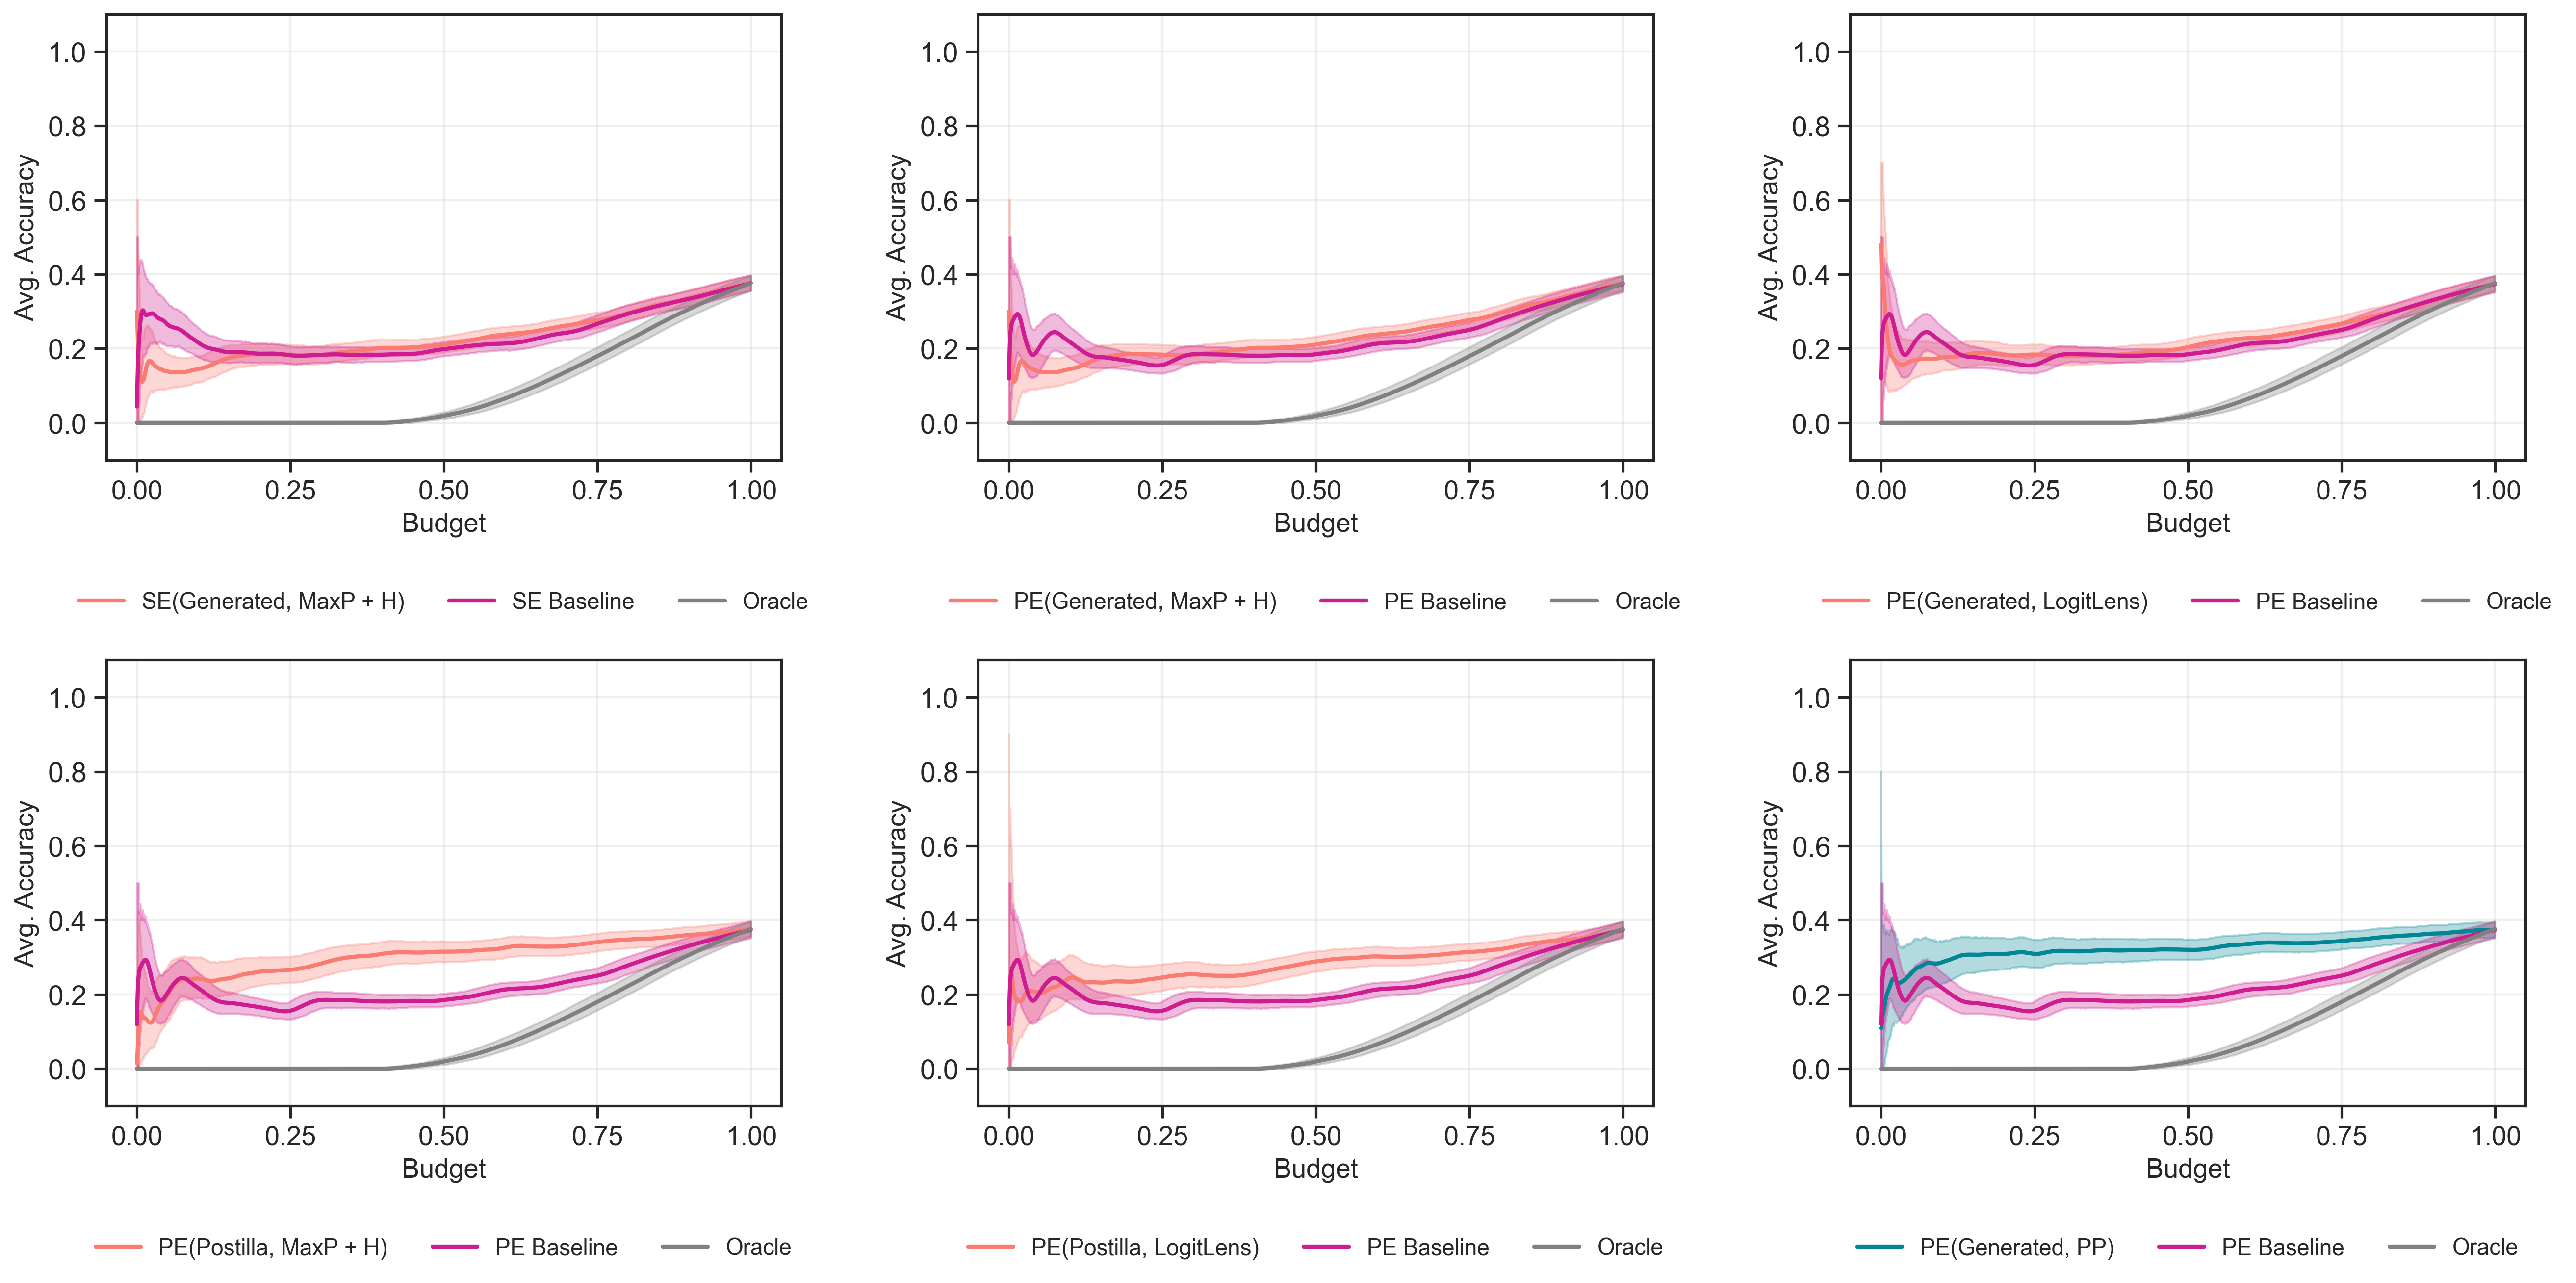

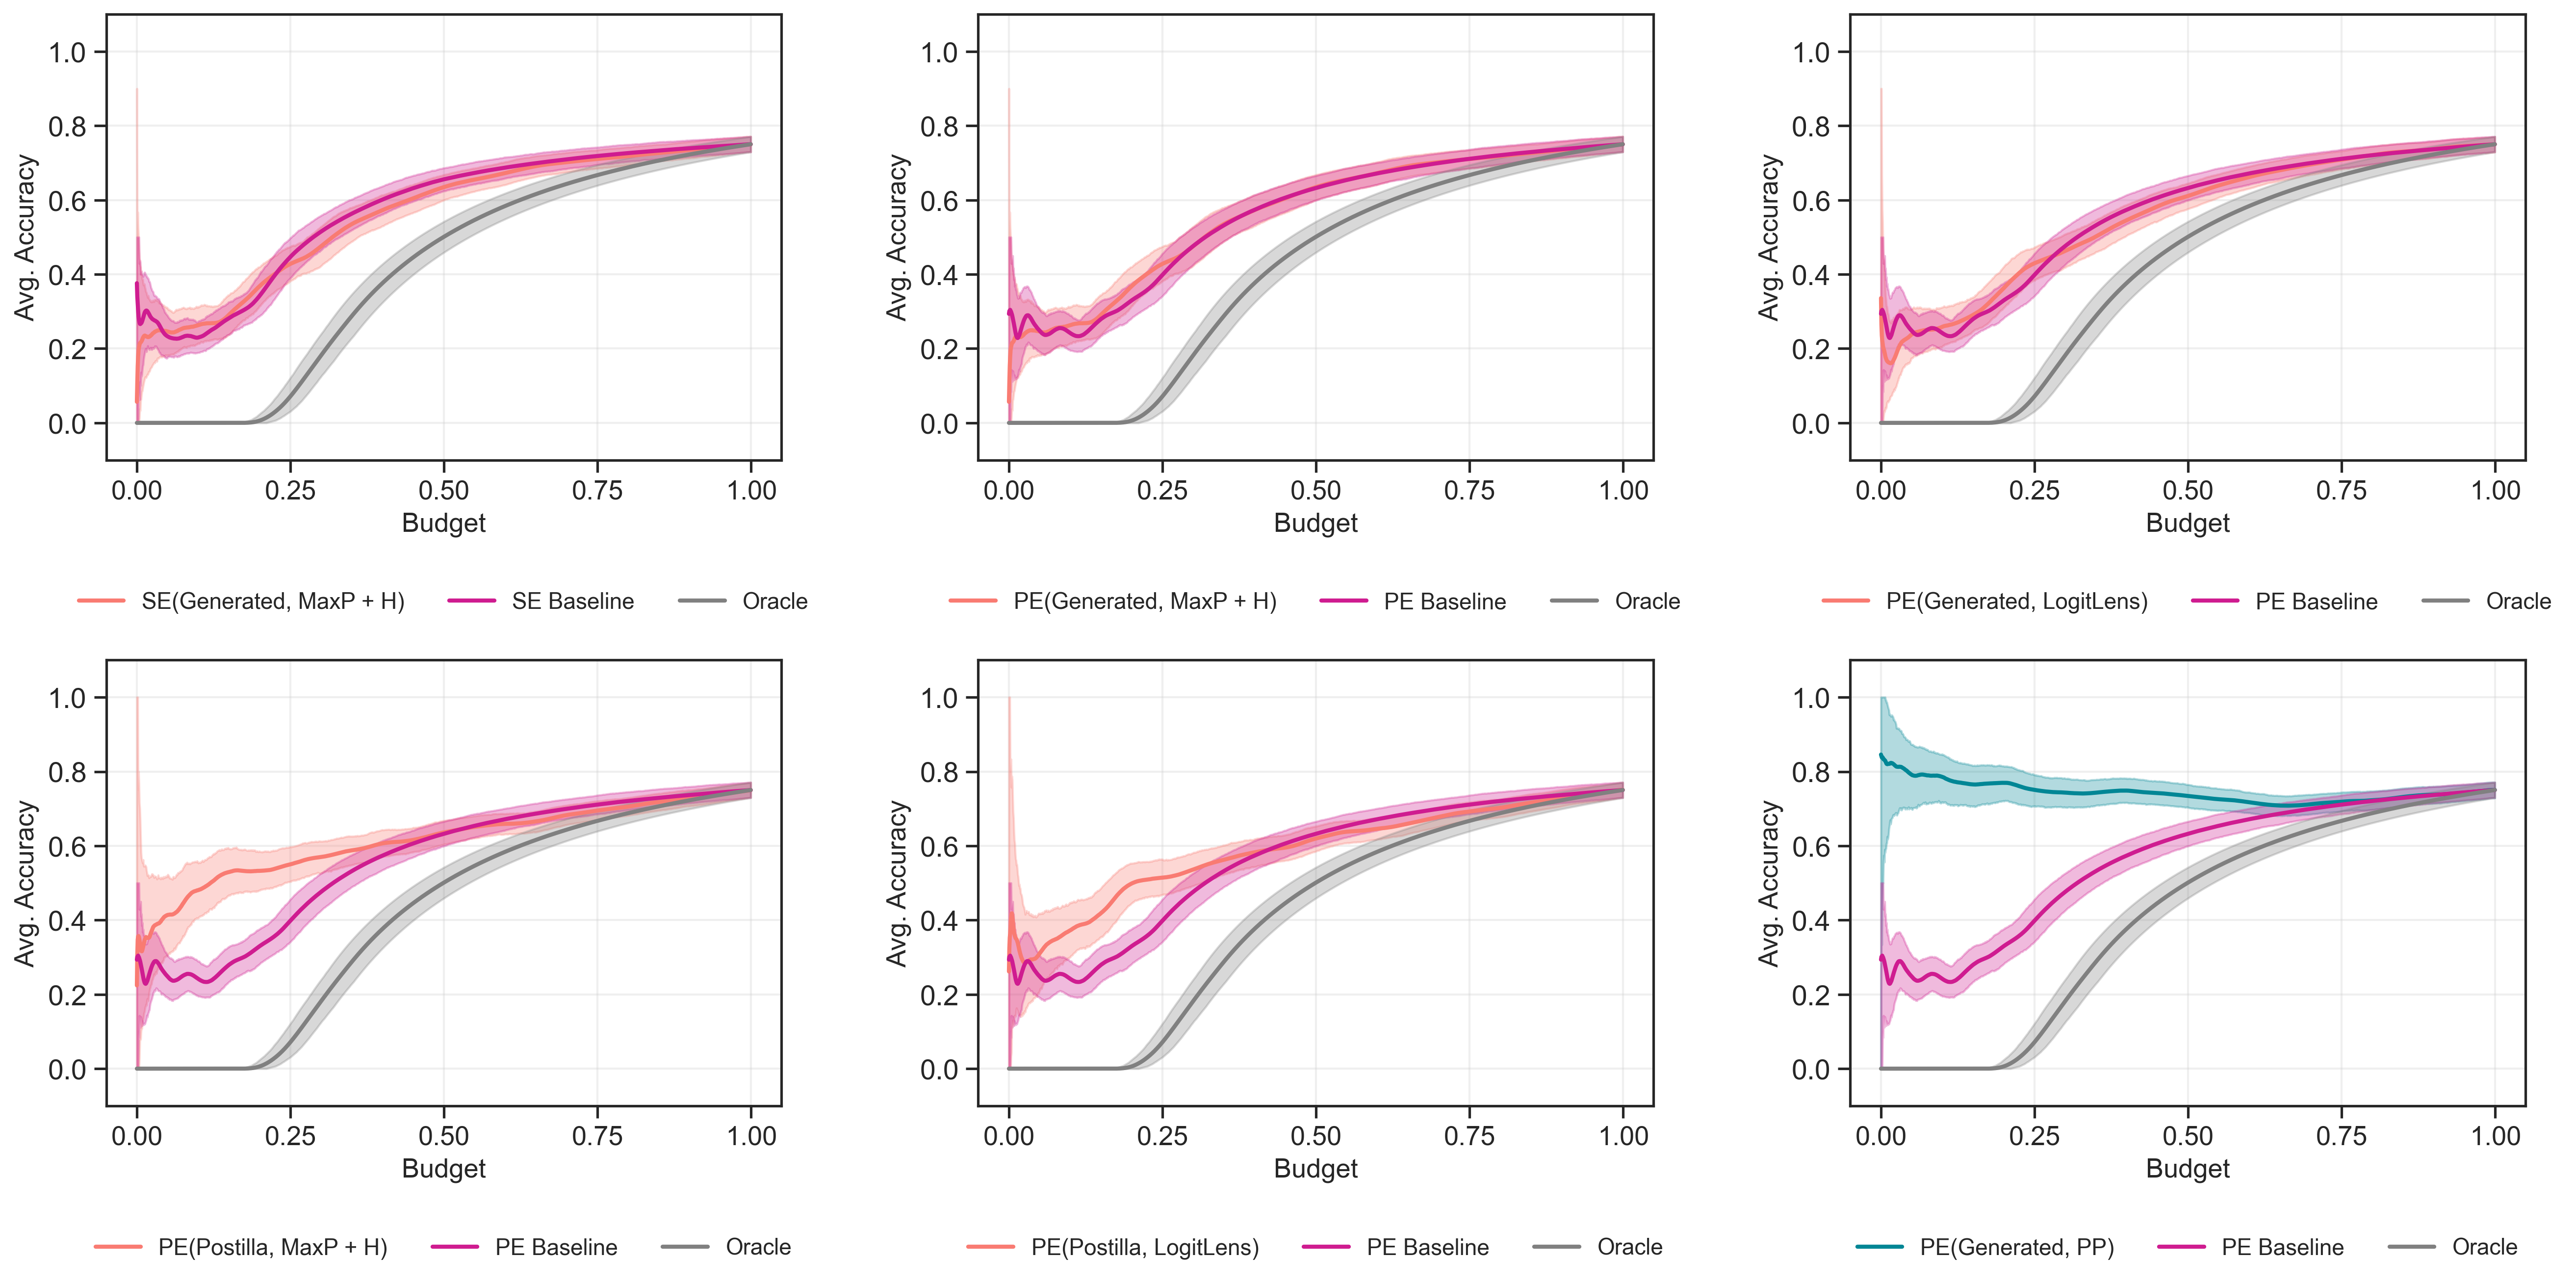

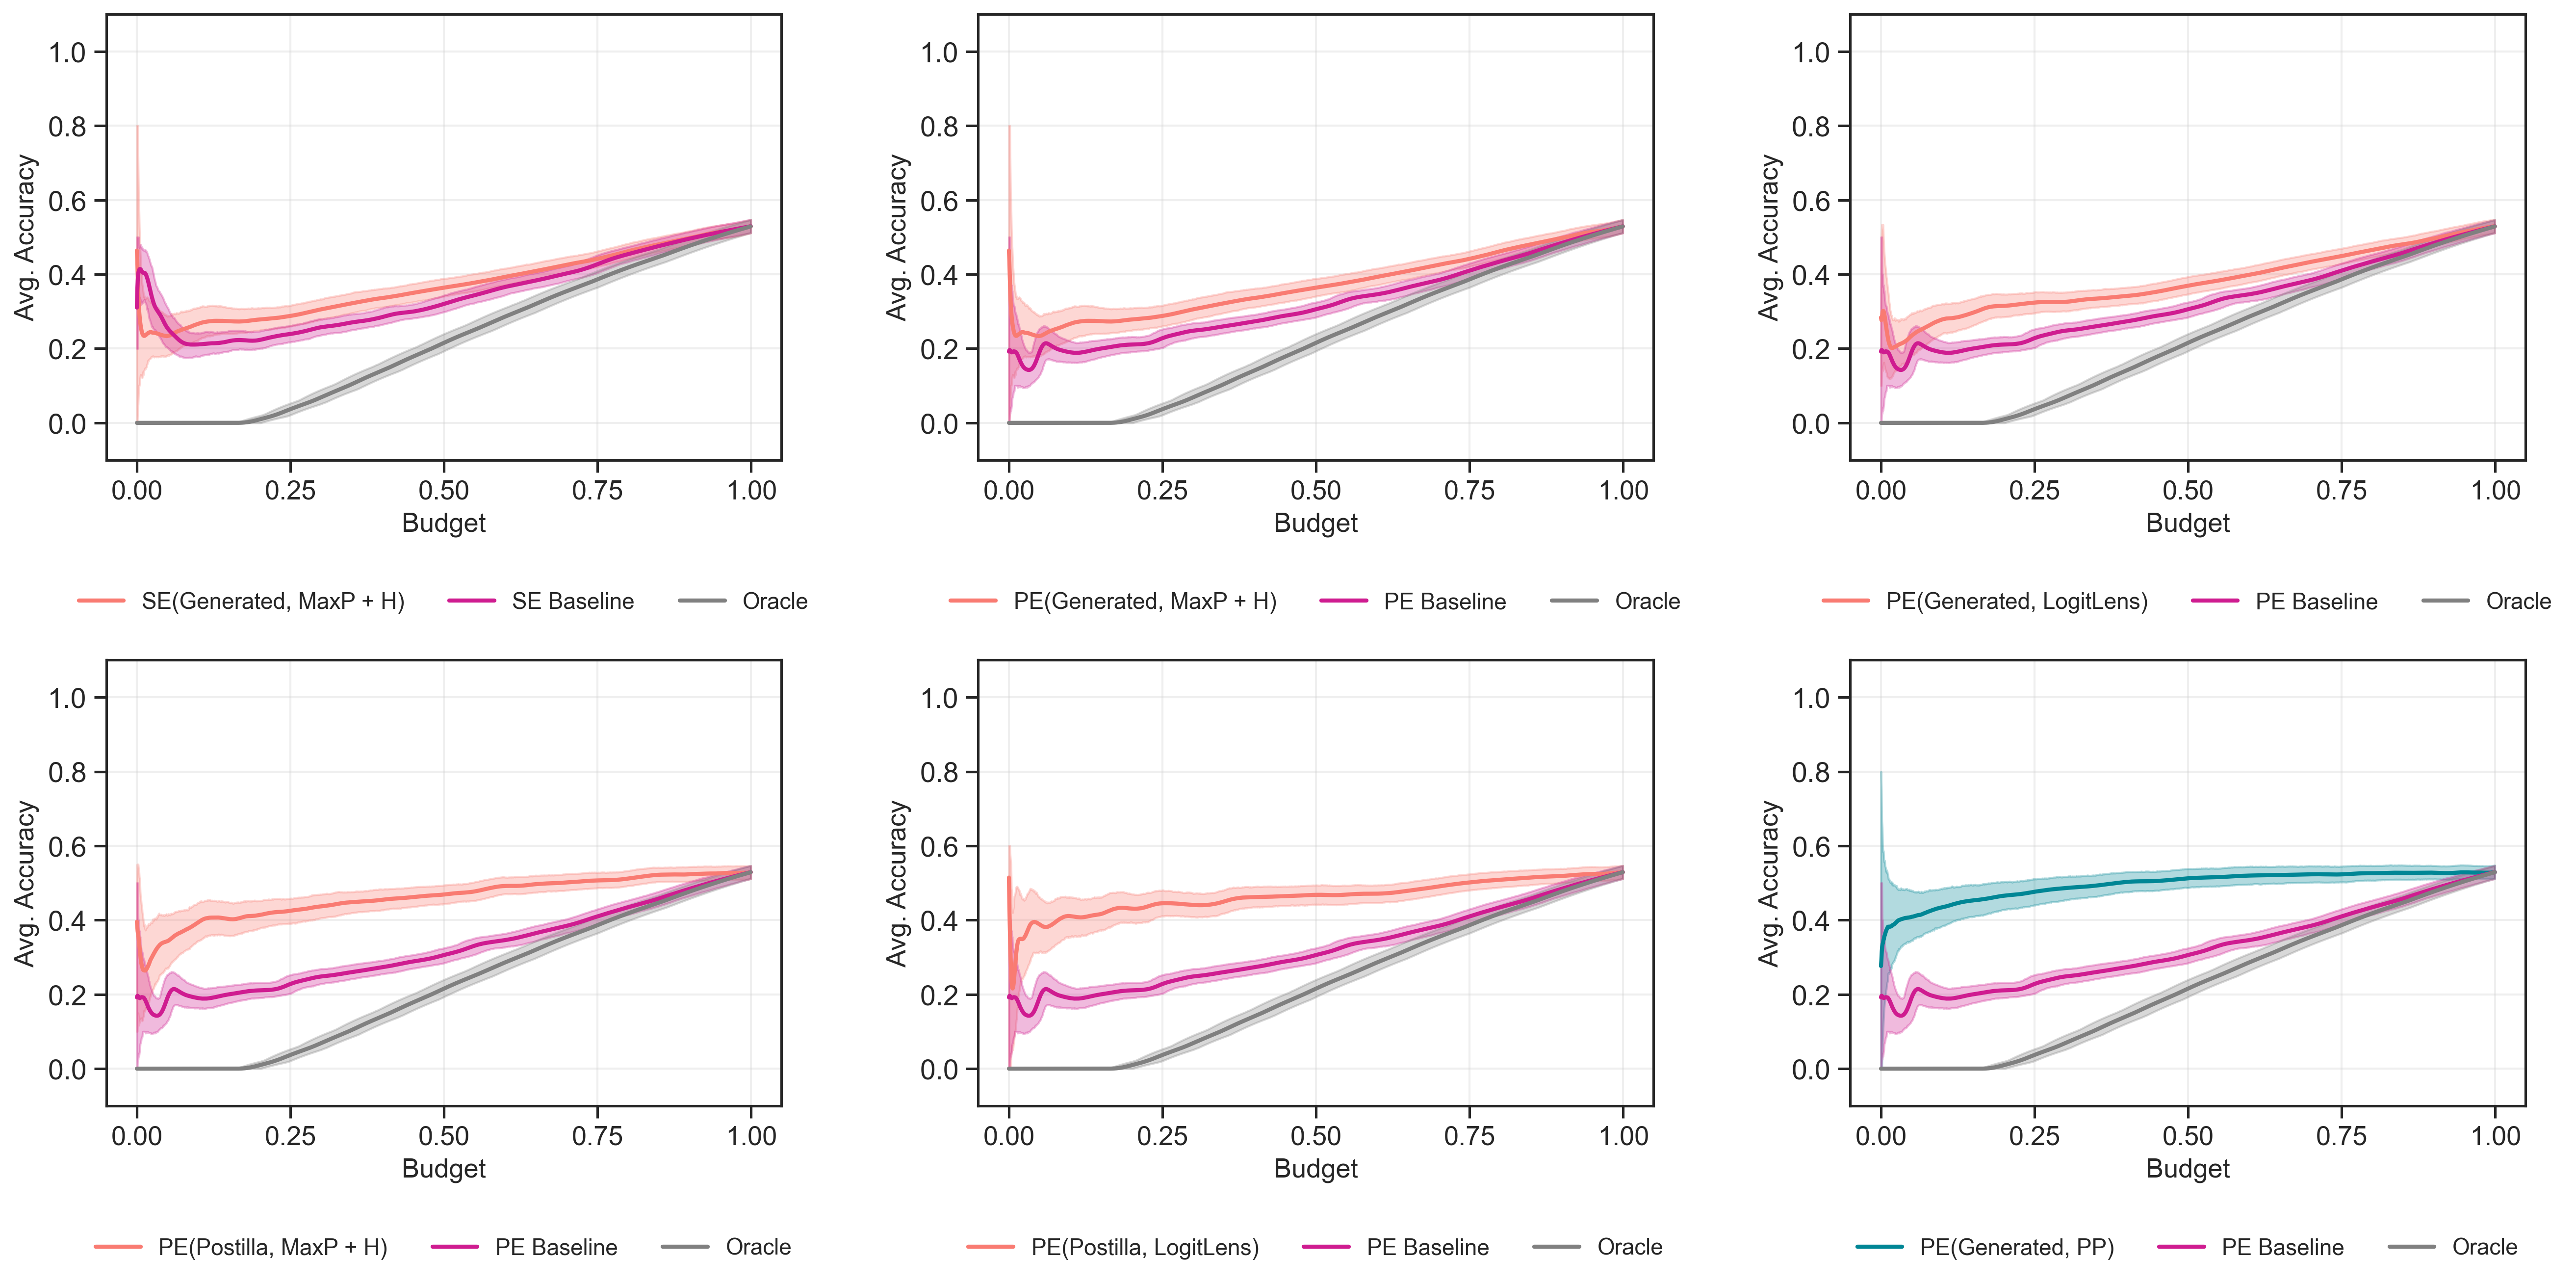

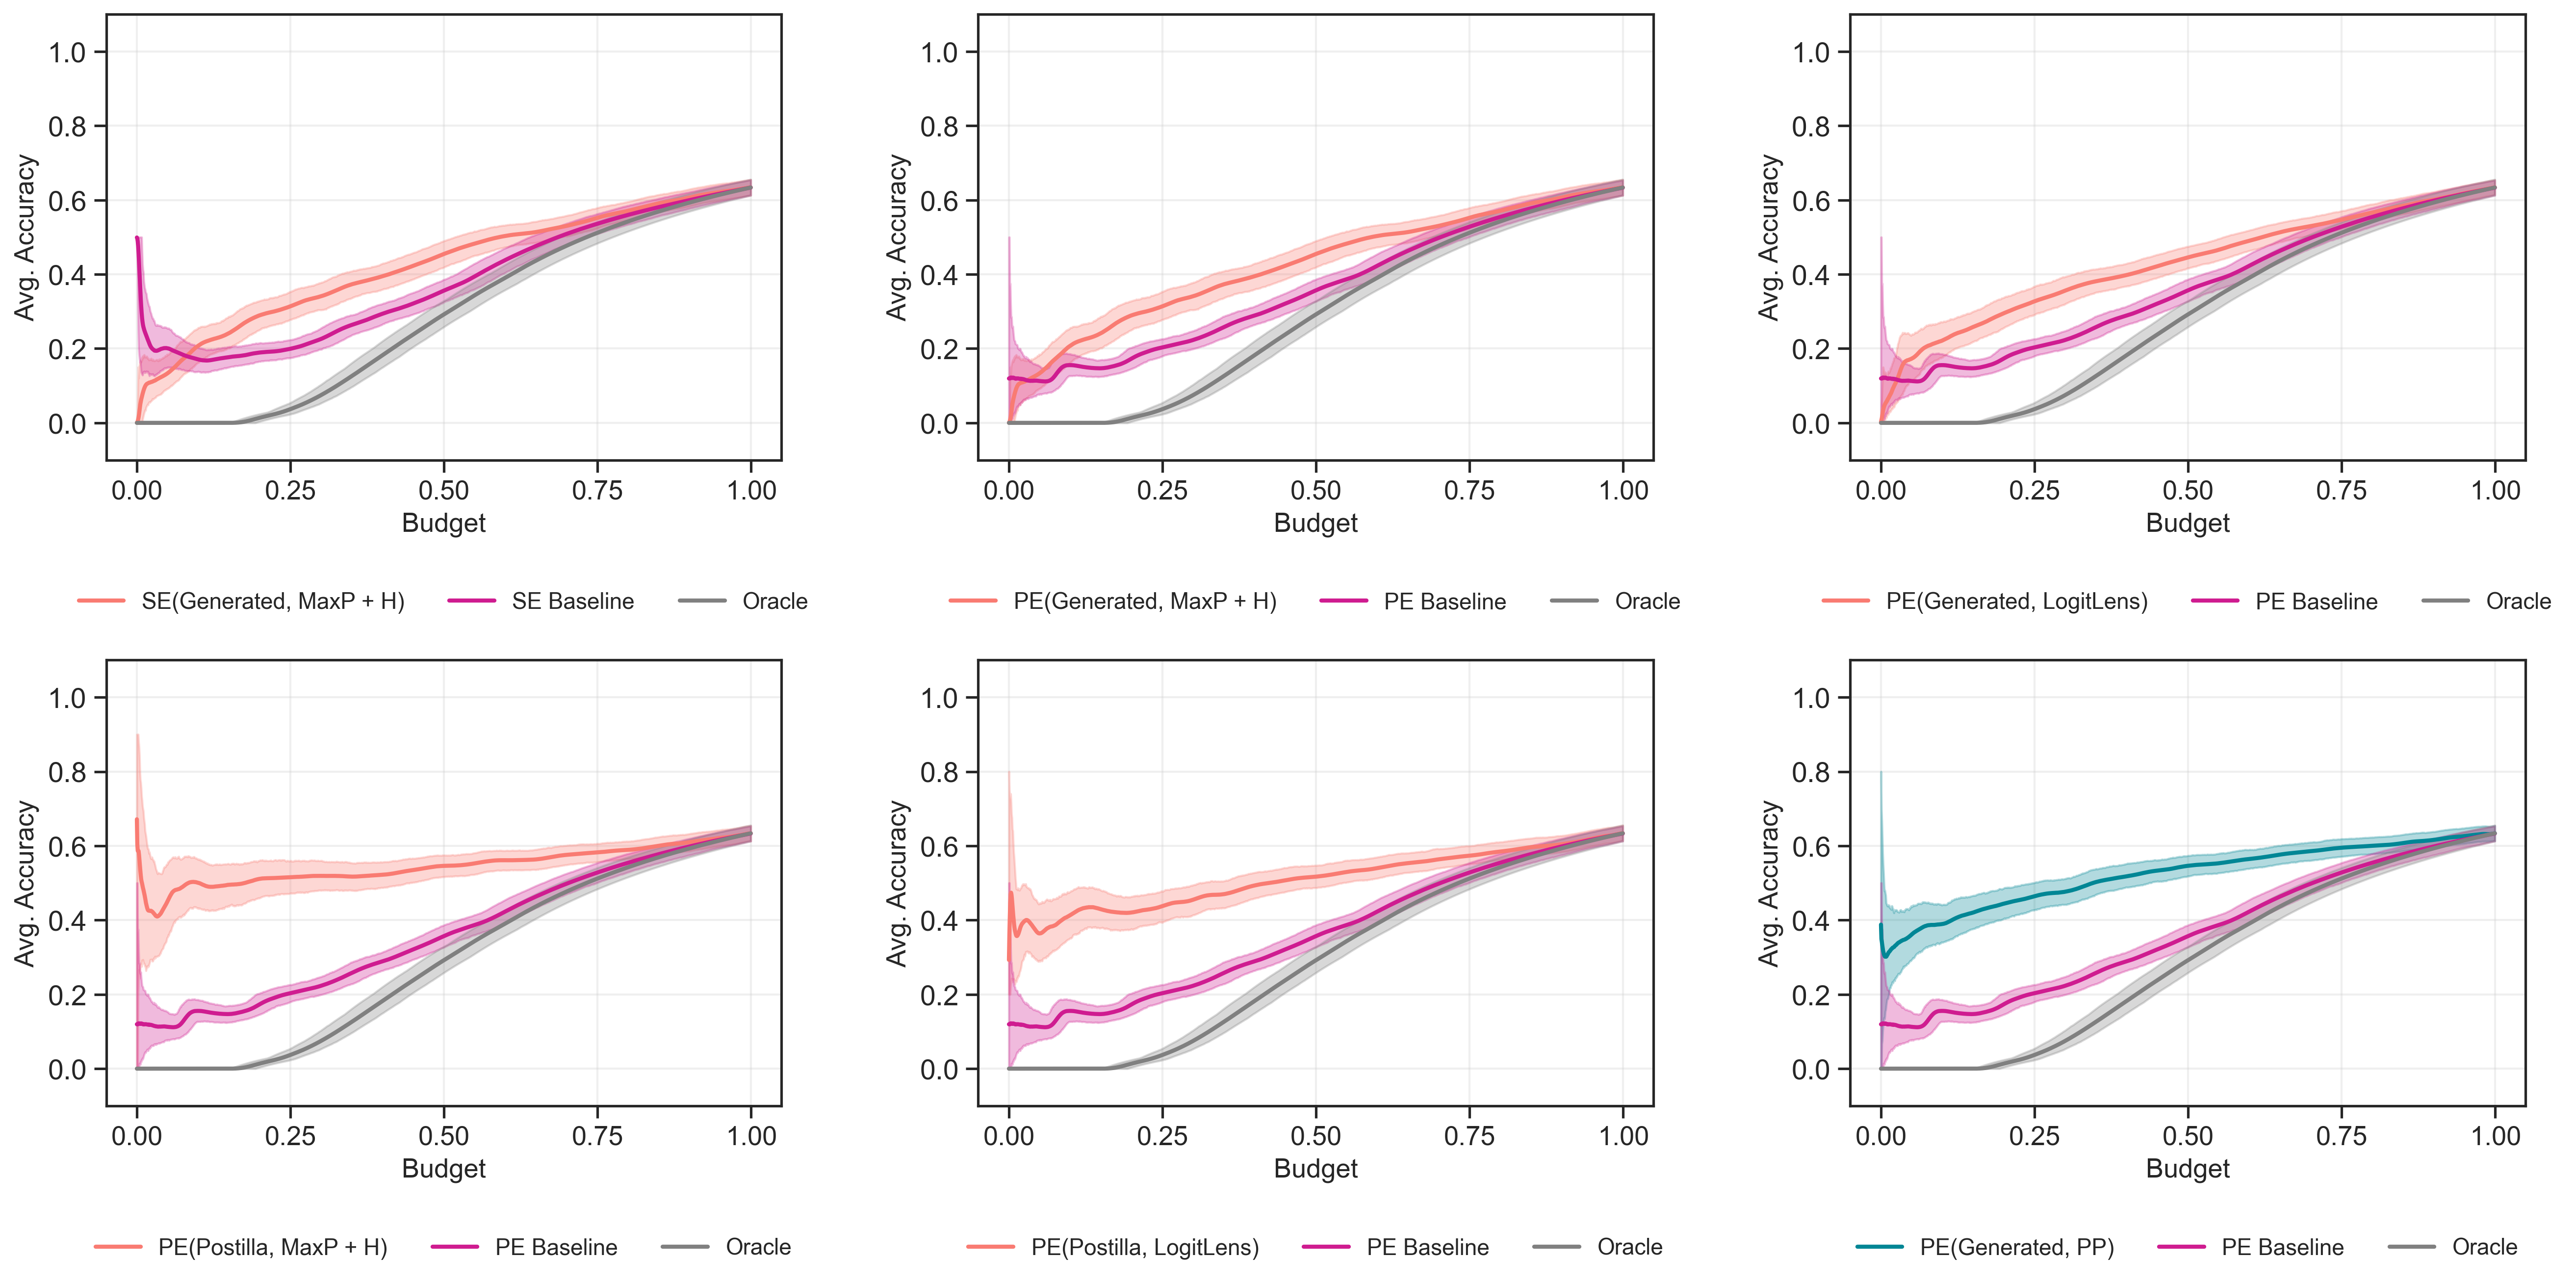

In [58]:
def prepare_pid_stats(
    df,
    pid_col="pid",
    weight_col="weight",
    target_col="Entropy",
    pred_col="pred_ent",
):
    """
    From the raw runs df, build a dict mapping each pid to:
      - N: number of runs
      - p: normalized weight vector (sum=1)
      - x_pred, x_true, x_acc: NumPy arrays of pred_ent, Entropy, correct_mean
    """
    pid_groups = {}
    for pid, g in df.groupby(pid_col):
        p = g[weight_col].to_numpy()
        N = len(p)
        pid_groups[pid] = {
            "N": N,
            "p": p,
            "x_pred": (
                1 - g[pred_col].to_numpy()
                if "correct_mean" in pred_col
                else g[pred_col].to_numpy()
            ),
            "x_true": (
                1 - g[target_col].to_numpy()
                if "correct_mean" in target_col
                else g[target_col].to_numpy()
            ),
            "x_acc": g["correct_mean"].to_numpy(),
        }
    return pid_groups


def summarize(curves):
    return (
        curves.mean(axis=0),
        np.percentile(curves, 2.5, axis=0),
        np.percentile(curves, 97.5, axis=0),
    )


def bootstrap_two_level(
    pid_groups: dict,
    n_prompts: int,
    n_bootstraps: int = 1000,
    n_bootstrap_samples: int = 10,
    sort_by: str = "pred",  # "pred" or "true"
):
    """
    Performs two-level bootstrap:
      A) sample pids with replacement (size=n_prompts)
      B) for each sampled pid, draw multinomial counts for its runs
         according to the pid's weight-distribution
      C) compute weighted mean per-pid for pred_ent / true_ent / acc
      D) sort by the chosen target and build cumulative mean of acc
    Returns array shape (n_bootstraps, n_prompts).
    """
    pid_list = list(pid_groups.keys())
    curves = np.zeros((n_bootstraps, n_prompts))

    for b in range(n_bootstraps):
        # A) sample pids
        sampled = np.random.choice(pid_list, size=n_prompts, replace=True)
        means_target = np.empty(n_prompts)
        means_acc = np.empty(n_prompts)

        # B+C) multinomial sampling + weighted means
        for i, pid in enumerate(sampled):
            rec = pid_groups[pid]
            c = np.random.multinomial(n_bootstrap_samples, rec["p"])
            means_target[i] = np.dot(c, rec[f"x_{sort_by}"]) / n_bootstrap_samples
            means_acc[i] = np.dot(c, rec["x_acc"]) / n_bootstrap_samples

        # D) sort by target & cumulative mean of accuracy
        order = np.argsort(-means_target)
        sorted_acc = means_acc[order]
        curves[b] = np.cumsum(sorted_acc) / np.arange(1, n_prompts + 1)
    return curves


n_bootstraps = 1000
for model_name in features_df:
    ncols = 3
    nrows = int(np.ceil((len(features_df[model_name]) + 1) / ncols))
    fig, axes = plt.subplots(
        figsize=(9 * nrows, 9),
        nrows=nrows,
        ncols=ncols,
        sharex=False,
        sharey=False,
        dpi=300,
    )
    # fig.suptitle(
    #     f"Cumulative Avg. Accuracy vs Entropy-Ranked Prompts | {model_name}",
    #     fontsize=17,
    #     y=1.0,
    # )
    axes = axes.flatten() if isinstance(axes, np.ndarray) else np.array([axes])

    bootstrap_cache = {}
    for i, target in enumerate(features_df[model_name]):
        ax = axes[i]
        df = features_df[model_name][target].copy()

        pid_groups = prepare_pid_stats(
            df,
            pid_col="pid",
            weight_col="weight",
            target_col=target[1],
            pred_col="pred_ent",
        )
        n_prompts = len(pid_groups)
        if target[0] not in bootstrap_cache:
            print(f"Bootstrapping {target[0]}")
            boot = bootstrap_two_level(
                pid_groups, n_prompts, n_bootstraps=n_bootstraps, sort_by="pred"
            )
            m, l, u = summarize(boot)
            x = 100 * np.arange(n_prompts) / n_prompts
            bootstrap_cache[target[0]] = (m, l, u, x)
        if target[1] not in bootstrap_cache:
            print(f"Bootstrapping {target[1]}")
            boot = bootstrap_two_level(
                pid_groups, n_prompts, n_bootstraps=n_bootstraps, sort_by="true"
            )
            m, l, u = summarize(boot)
            x = 100 * np.arange(n_prompts) / n_prompts
            bootstrap_cache[target[1]] = (m, l, u, x)

        m_pred, l_pred, u_pred, x = bootstrap_cache[target[0]]
        ax.plot(
            x,
            m_pred,
            label=f"{target[1]}({target[0]})",
            lw=2,
            color=Bold_10.mpl_colors[-1],
        )
        ax.fill_between(x, l_pred, u_pred, alpha=0.3, color=Bold_10.mpl_colors[-1])

        m_true, l_true, u_true, x = bootstrap_cache[target[1]]
        ax.plot(
            x,
            m_true,
            label=f"{target[1]} Baseline",
            lw=2,
            color=Bold_10.mpl_colors[-2],
        )
        ax.fill_between(x, l_true, u_true, alpha=0.3, color=Bold_10.mpl_colors[-2])

        # Compute the Oracle
        pid_groups = prepare_pid_stats(
            df,
            pid_col="pid",
            weight_col="weight",
            target_col="correct_mean",
            pred_col="correct_mean",
        )
        n_prompts = len(pid_groups)
        if "Oracle" not in bootstrap_cache:
            print(f"Bootstrapping Oracle")
            boot = bootstrap_two_level(
                pid_groups, n_prompts, n_bootstraps=n_bootstraps, sort_by="pred"
            )
            m_pred, l_pred, u_pred = summarize(boot)
            x = 100 * np.arange(n_prompts) / n_prompts
            bootstrap_cache["Oracle"] = (m_pred, l_pred, u_pred, x)
        m_pred, l_pred, u_pred, x = bootstrap_cache["Oracle"]
        ax.plot(x, m_pred, label=f"Oracle", lw=2, color="grey")
        ax.fill_between(x, l_pred, u_pred, alpha=0.3, color="grey")

        ax.legend(fontsize=9, title="", frameon=False)
        sns.move_legend(
            ax,
            loc="upper center",
            bbox_to_anchor=(0.5, -0.25),
            ncol=3,
            fontsize=11,
        )
        ax.set_xlabel("Budget", fontsize=13)
        ax.set_ylabel("Avg. Accuracy", fontsize=13)
        ax.grid(alpha=0.3)
        ax.set_xticks(
            np.arange(0, 101, 25),
            labels=[f"{x / 100:.2f}" for x in np.arange(0, 101, 25)],
            fontsize=13,
        )

    # Compute the same but for perplexity vs entropy
    df = features_df[model_name][("Generated, MaxP + H", "PE")].copy()

    pid_groups = prepare_pid_stats(
        df,
        pid_col="pid",
        weight_col="weight",
        target_col="PE",
        pred_col="perplexity",
    )
    n_prompts = len(pid_groups)
    boot_pred = bootstrap_two_level(
        pid_groups, n_prompts, n_bootstraps=n_bootstraps, sort_by="pred"
    )
    m_pred, l_pred, u_pred = summarize(boot_pred)
    m_true, l_true, u_true, x = bootstrap_cache["PE"]

    ax = axes[i + 1]
    ax.plot(x, m_pred, label=f"PE(Generated, PP)", lw=2, color=Bold_10.mpl_colors[-3])
    ax.fill_between(x, l_pred, u_pred, alpha=0.3, color=Bold_10.mpl_colors[-3])
    ax.plot(x, m_true, label=f"PE Baseline", lw=2, color=Bold_10.mpl_colors[-2])
    ax.fill_between(x, l_true, u_true, alpha=0.3, color=Bold_10.mpl_colors[-2])

    # Compute the Oracle
    m_oracle, l_oracle, u_oracle, x = bootstrap_cache["Oracle"]
    ax.plot(x, m_oracle, label=f"Oracle", lw=2, color="grey")
    ax.fill_between(x, l_oracle, u_oracle, alpha=0.3, color="grey")

    ax.set_xticks(
        np.arange(0, 101, 25),
        labels=[f"{x / 100:.2f}" for x in np.arange(0, 101, 25)],
        fontsize=13,
    )

    ax.legend(fontsize=9, title="", frameon=False)
    sns.move_legend(
        ax,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.25),
        ncol=3,
        fontsize=11,
    )
    ax.set_xlabel("Budget", fontsize=13)
    ax.set_ylabel("Avg. Accuracy", fontsize=13)
    ax.grid(alpha=0.3)

    for h in range(len(axes)):
        axes[h].set_ylim(-0.1, 1.1)
        axes[h].tick_params(axis="y", which="both", labelleft=True)

    for j in range(i + 3, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.savefig(
        os.path.join(
            images_dir,
            f"bootstrapped_cumulative_accuracy_per_feature_{model_name}.png",
        ),
        bbox_inches="tight",
        dpi=300,
    )

### Accuracy recovered

Model TableLlama with target ('Generated, MaxP + H', 'PE')
Bootstrapping Generated, MaxP + H
Bootstrapping PE
Bootstrapping Perplexity
Bootstrapping Oracle
Model Gemma-2-2B-it with target ('Generated, MaxP + H', 'PE')
Bootstrapping Generated, MaxP + H
Bootstrapping PE
Bootstrapping Perplexity
Bootstrapping Oracle
Model Gemma-2-9B-it with target ('Generated, MaxP + H', 'PE')
Bootstrapping Generated, MaxP + H
Bootstrapping PE
Bootstrapping Perplexity
Bootstrapping Oracle
Model Llama-3.1-8B-it with target ('Generated, MaxP + H', 'PE')
Bootstrapping Generated, MaxP + H
Bootstrapping PE
Bootstrapping Perplexity
Bootstrapping Oracle
Model Qwen-2.5-7B-it with target ('Generated, MaxP + H', 'PE')
Bootstrapping Generated, MaxP + H
Bootstrapping PE
Bootstrapping Perplexity
Bootstrapping Oracle


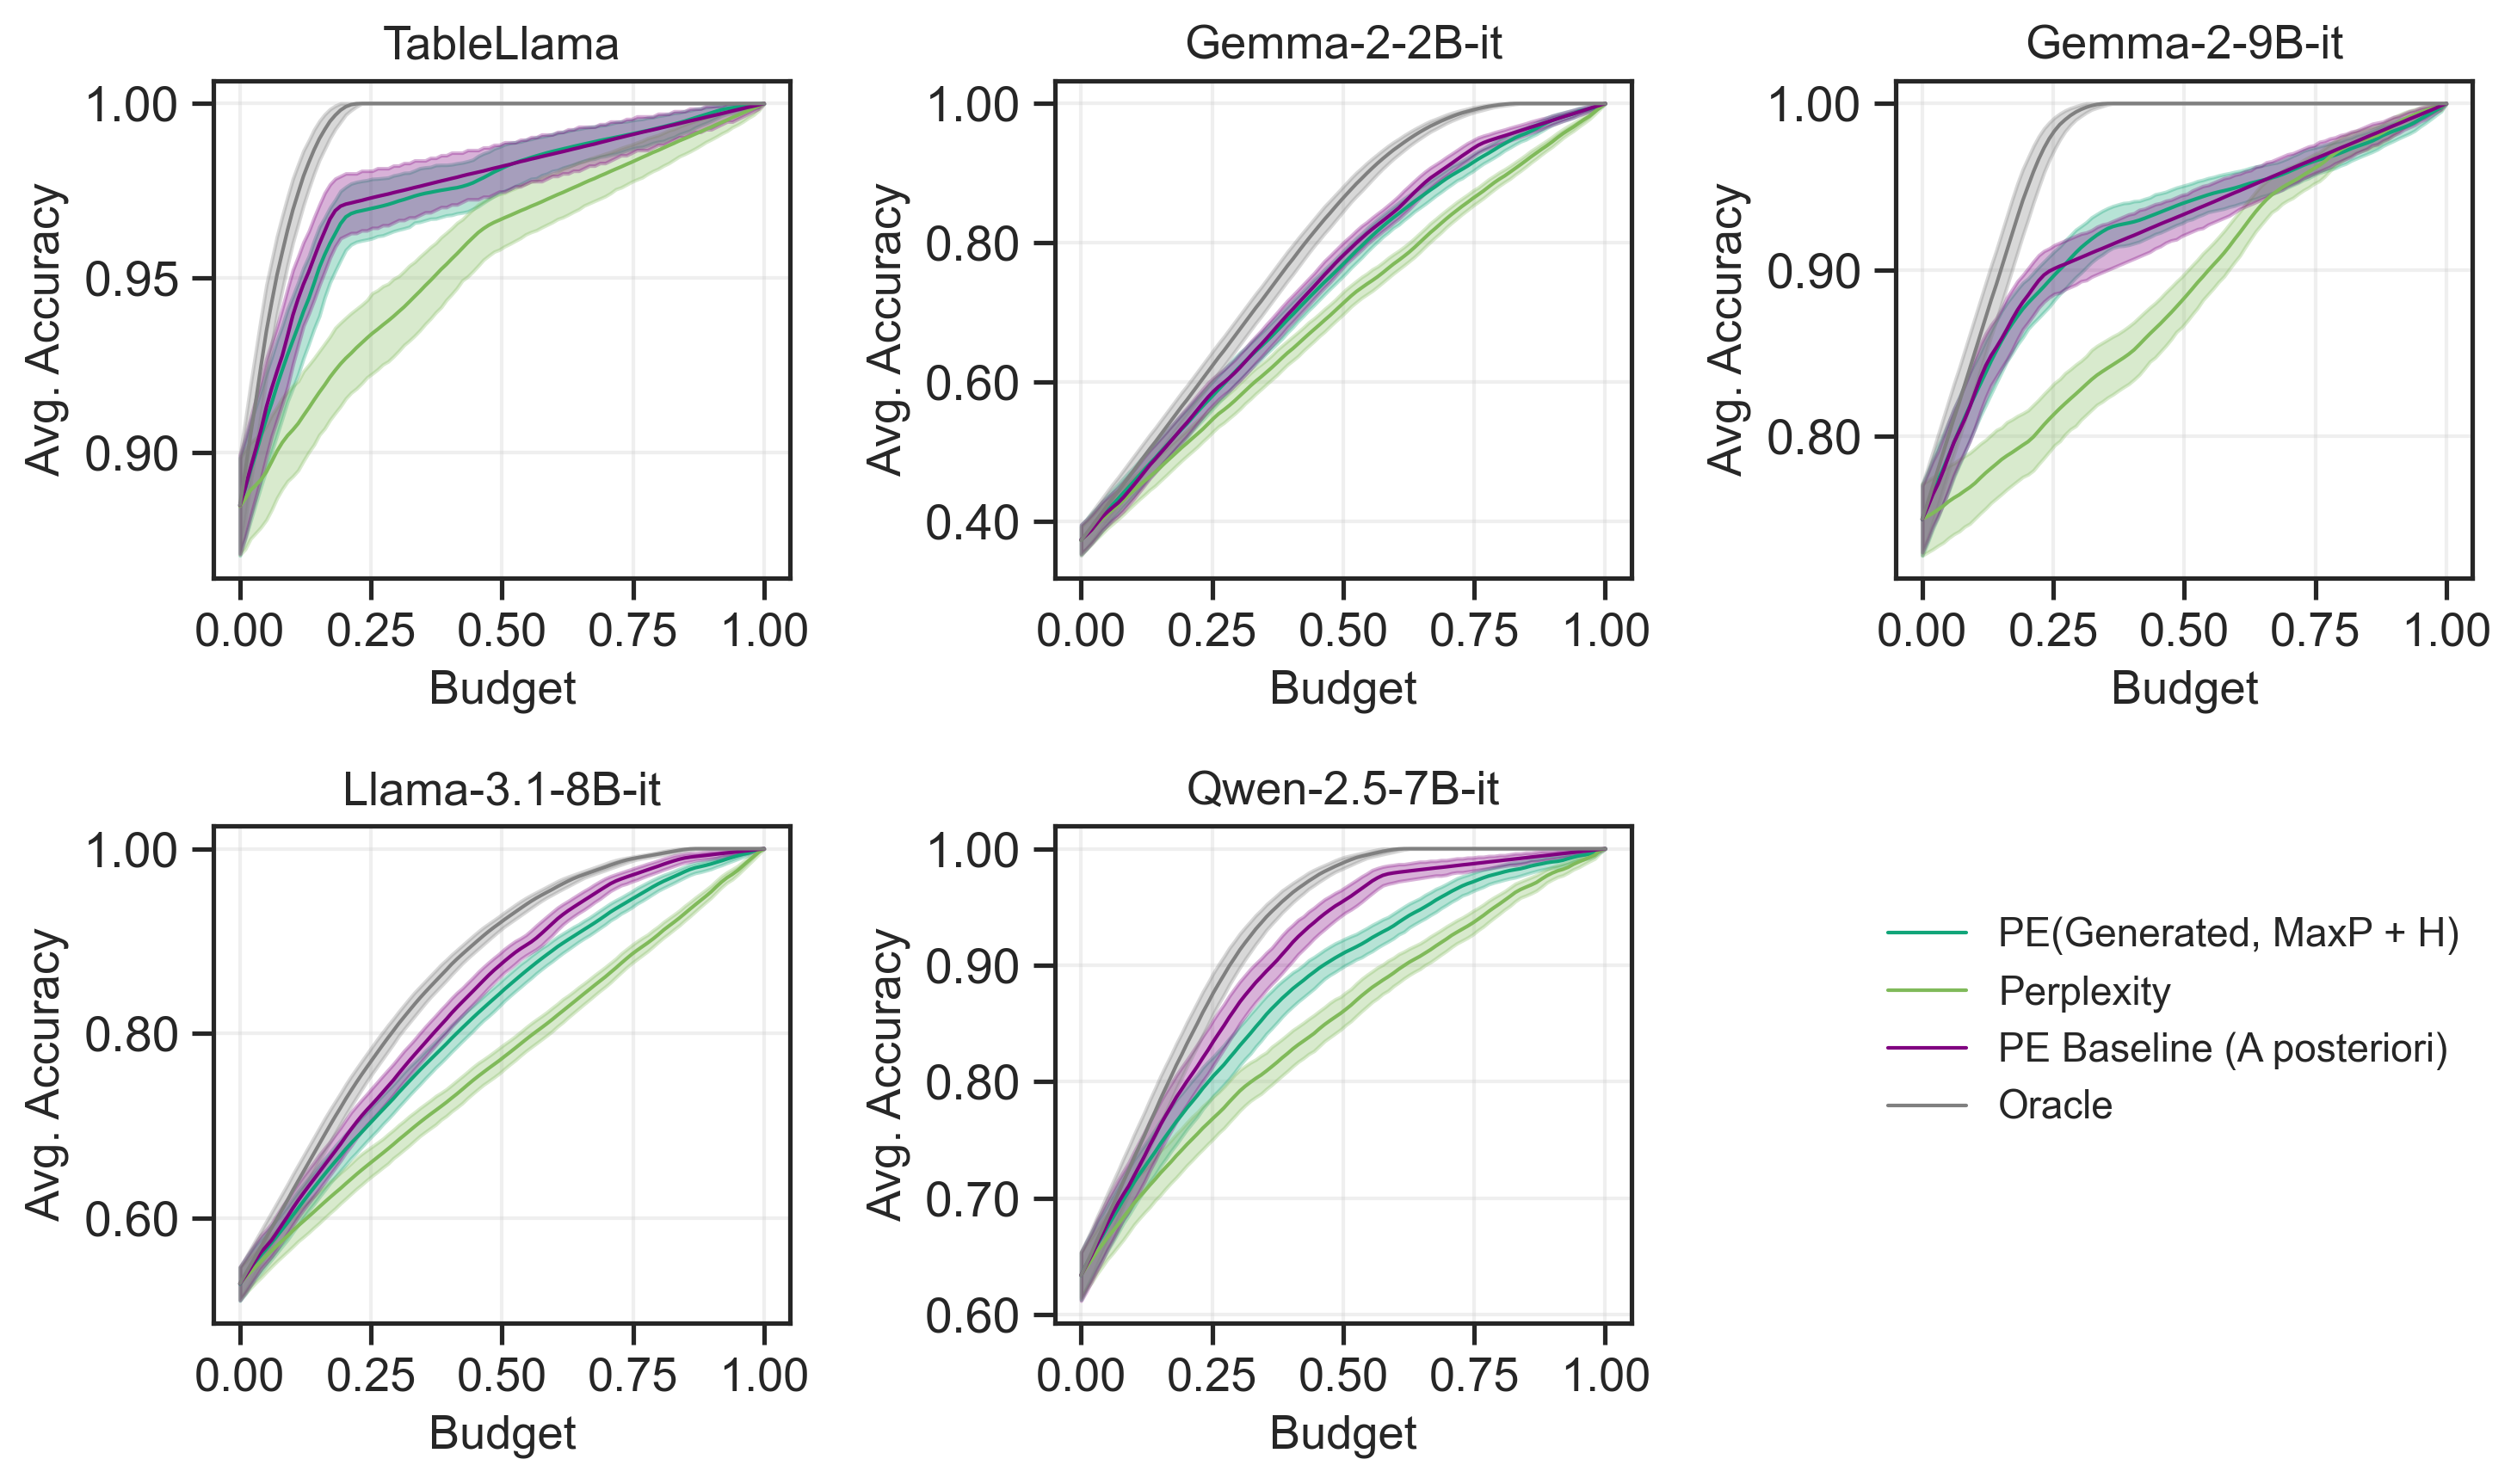

In [22]:
def prepare_pid_stats(
    df,
    pid_col="pid",
    weight_col="weight",
    target_col="Entropy",
    pred_col="pred_ent",
):
    """
    From the raw runs df, build a dict mapping each pid to:
      - N: number of runs
      - p: normalized weight vector (sum=1)
      - x_pred, x_true, x_acc: NumPy arrays of pred_ent, Entropy, correct_mean
    """
    pid_groups = {}
    for pid, g in df.groupby(pid_col):
        p = g[weight_col].to_numpy()
        N = len(p)
        pid_groups[pid] = {
            "N": N,
            "p": p,
            "x_pred": (
                1 - g[pred_col].to_numpy()
                if "correct_mean" in pred_col
                else g[pred_col].to_numpy()
            ),
            "x_true": (
                1 - g[target_col].to_numpy()
                if "correct_mean" in target_col
                else g[target_col].to_numpy()
            ),
            "x_acc": g["correct_mean"].to_numpy(),
        }
    return pid_groups


def summarize(curves):
    return (
        curves.mean(axis=0),
        np.percentile(curves, 2.5, axis=0),
        np.percentile(curves, 97.5, axis=0),
    )


def bootstrap_two_level_with_oracle_fraction(
    pid_groups: dict,
    n_prompts: int,
    n_bootstraps: int = 1000,
    n_bootstrap_samples: int = 10,
    sort_by: str = "pred",  # "pred" or "true"
    n_fractions: int = 100,  # granularity of oracle coverage curve
):
    """
    For each oracle fraction ∈ [0,1], compute the hybrid accuracy where:
        - top-frac prompts (most uncertain) are corrected (accuracy=1)
        - remaining prompts use model accuracy
    Returns:
        - oracle_fracs: array of length n_fractions
        - mean, lower, upper bounds: each of shape (n_fractions,)
    """
    pid_list = list(pid_groups.keys())
    oracle_fracs = np.linspace(0, 1, n_fractions)
    accuracies = np.zeros((n_bootstraps, n_fractions))

    for b in range(n_bootstraps):
        sampled = np.random.choice(pid_list, size=n_prompts, replace=True)
        means_target = np.empty(n_prompts)
        means_acc = np.empty(n_prompts)

        # Sample accuracy and sorting values
        for i, pid in enumerate(sampled):
            rec = pid_groups[pid]
            c = np.random.multinomial(n_bootstrap_samples, rec["p"])
            means_target[i] = np.dot(c, rec[f"x_{sort_by}"]) / n_bootstrap_samples
            means_acc[i] = np.dot(c, rec["x_acc"]) / n_bootstrap_samples

        # Sort prompts by descending predicted uncertainty
        order = np.argsort(-means_target)
        sorted_acc = means_acc[order]

        # For each oracle fraction, compute hybrid accuracy
        for j, frac in enumerate(oracle_fracs):
            n_oracle = int(frac * n_prompts)
            oracle_acc = np.ones(n_oracle)
            model_acc = sorted_acc[n_oracle:]
            hybrid_acc = np.concatenate([oracle_acc, model_acc])
            accuracies[b, j] = hybrid_acc.mean()

    return oracle_fracs * 100, accuracies


ncols = 3
nrows = int(np.ceil(len(features_df) / ncols))
fig, axes = plt.subplots(
    figsize=(5 * nrows, 6),
    nrows=nrows,
    ncols=ncols,
    sharex=False,
    sharey=False,
    dpi=300,
)
# fig.suptitle(
#     f"Cumulative Avg. Accuracy vs Entropy-Ranked Prompts After Correction", fontsize=17
# )
axes = axes.flatten() if isinstance(axes, np.ndarray) else np.array([axes])

n_bootstraps = 1000
for i, model_name in enumerate(features_df):
    ax = axes[i]
    target = ("Generated, MaxP + H", "PE")
    print(f"Model {model_name} with target {target}")
    df = features_df[model_name][target]

    pid_groups = prepare_pid_stats(
        df,
        pid_col="pid",
        weight_col="weight",
        target_col=target[1],
        pred_col="pred_ent",
    )
    n_prompts = len(pid_groups)

    print(f"Bootstrapping {target[0]}")
    x, boot = bootstrap_two_level_with_oracle_fraction(
        pid_groups, n_prompts, n_bootstraps=n_bootstraps, sort_by="pred"
    )
    m_pred, l_pred, u_pred = summarize(boot)

    print(f"Bootstrapping {target[1]}")
    x, boot = bootstrap_two_level_with_oracle_fraction(
        pid_groups, n_prompts, n_bootstraps=n_bootstraps, sort_by="true"
    )
    m_true, l_true, u_true = summarize(boot)

    print(f"Bootstrapping Perplexity")
    pid_groups = prepare_pid_stats(
        df,
        pid_col="pid",
        weight_col="weight",
        target_col=target[1],
        pred_col="perplexity",
    )
    n_prompts = len(pid_groups)
    x, boot = bootstrap_two_level_with_oracle_fraction(
        pid_groups, n_prompts, n_bootstraps=n_bootstraps, sort_by="pred"
    )
    m_pp, l_pp, u_pp = summarize(boot)

    ax.plot(
        x,
        m_pred,
        label=f"{target[1]}({target[0]})",
        lw=1,
        color=palette[f"{target[1]}({target[0]})"],
    )
    ax.fill_between(
        x,
        l_pred,
        u_pred,
        alpha=0.3,
        color=palette[f"{target[1]}({target[0]})"],
    )

    ax.plot(
        x,
        m_pp,
        label=f"{target[1]}(Generated, PP)",
        lw=1,
        color=palette["PE(Generated, PP)"],
    )
    ax.fill_between(
        x,
        l_pp,
        u_pp,
        alpha=0.3,
        color=palette["PE(Generated, PP)"],
    )

    ax.plot(
        x,
        m_true,
        label=f"{target[1]} Baseline",
        lw=1,
        color="purple",
    )
    ax.fill_between(
        x,
        l_true,
        u_true,
        alpha=0.3,
        color="purple",
    )

    print("Bootstrapping Oracle")
    pid_groups = prepare_pid_stats(
        df,
        pid_col="pid",
        weight_col="weight",
        target_col="correct_mean",
        pred_col="correct_mean",
    )
    n_prompts = len(pid_groups)
    x, boot = bootstrap_two_level_with_oracle_fraction(
        pid_groups, n_prompts, n_bootstraps=n_bootstraps, sort_by="pred"
    )
    m_pred, l_pred, u_pred = summarize(boot)

    ax.plot(
        x,
        m_pred,
        label=f"Oracle",
        lw=1,
        color="grey",
    )
    ax.fill_between(
        x,
        l_pred,
        u_pred,
        alpha=0.3,
        color="grey",
    )

    if i == 0:
        ax.legend(fontsize=11, title="", ncol=3)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend().remove()
    ax.set_xlabel("Budget", fontsize=13)
    ax.set_xticks(
        np.arange(0, 101, 25),
        labels=[f"{x / 100:.2f}" for x in np.arange(0, 101, 25)],
        fontsize=13,
    )
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    ax.set_ylabel("Avg. Accuracy", fontsize=13)
    ax.set_title(f"{model_name}", fontsize=13)
    ax.grid(alpha=0.3)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

# Legend to the right of the last plot
updated_labels = []
for l in labels:
    if "PP" in l:
        updated_labels.append("Perplexity")
    elif "Baseline" in l:
        if "MaxP" not in l and "Token-Entropy" not in l:
            updated_labels.append(l + " (A posteriori)")
        else:
            updated_labels.append(l)
    else:
        updated_labels.append(l)
fig.legend(
    handles,
    updated_labels,
    loc="upper left",
    bbox_to_anchor=(0.73, 0.41),
    ncol=1,
    fontsize=11,
    frameon=False,
)
plt.tight_layout()
plt.savefig(
    os.path.join(
        images_dir, "bootstrapped_cumulative_accuracy_per_model_after_correction.png"
    ),
    bbox_inches="tight",
    dpi=300,
)

Model TableLlama
Model Gemma-2-2B-it
Model Gemma-2-9B-it
Model Llama-3.1-8B-it
Model Qwen-2.5-7B-it


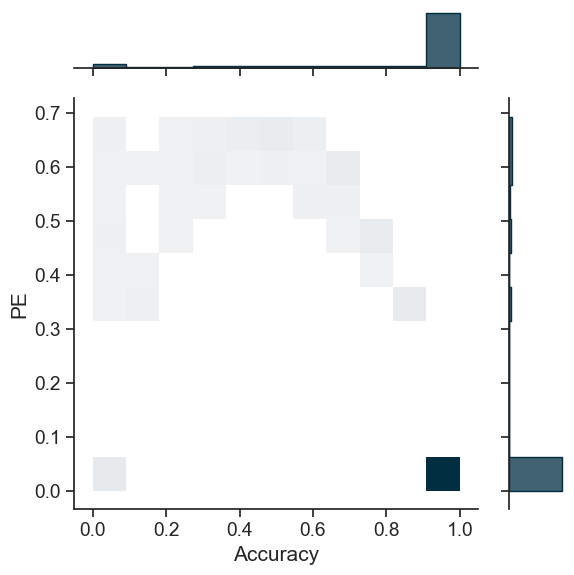

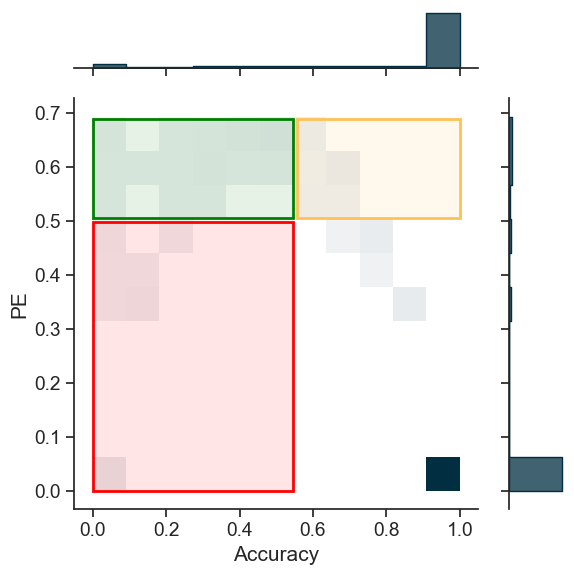

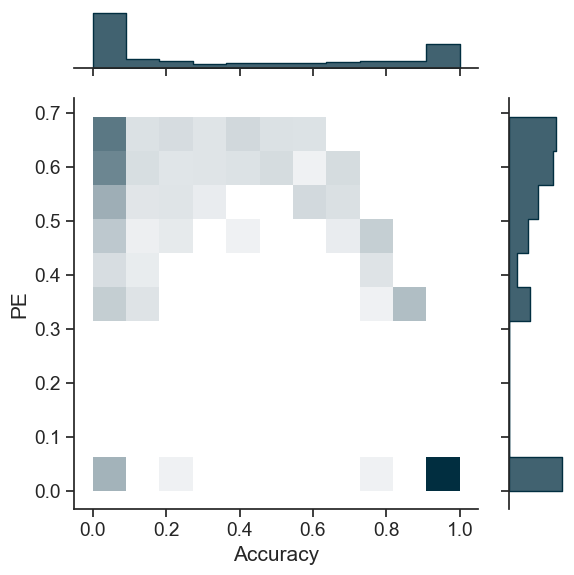

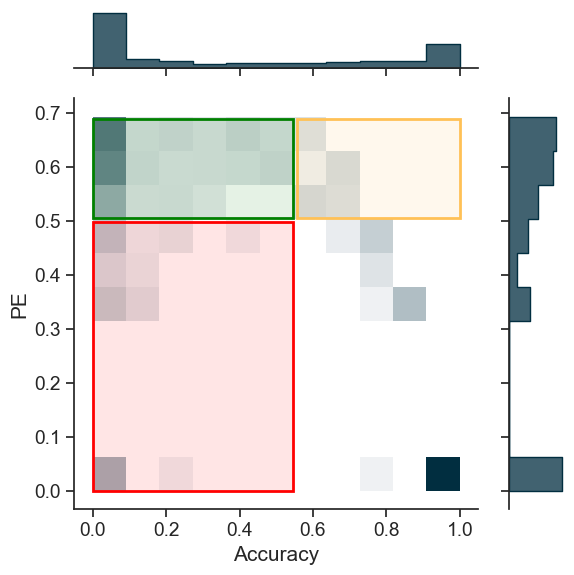

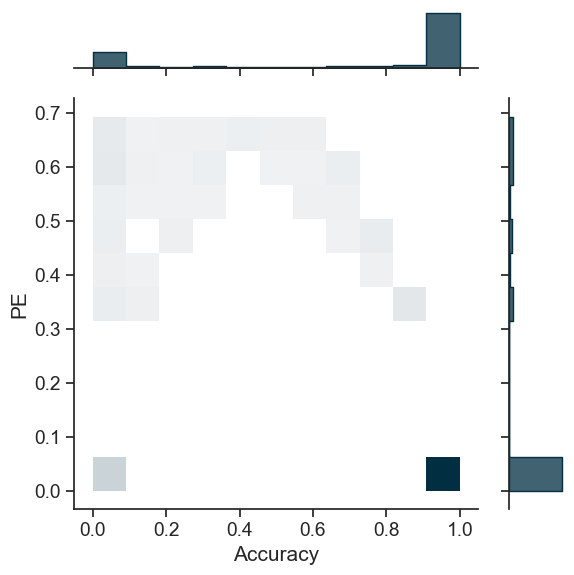

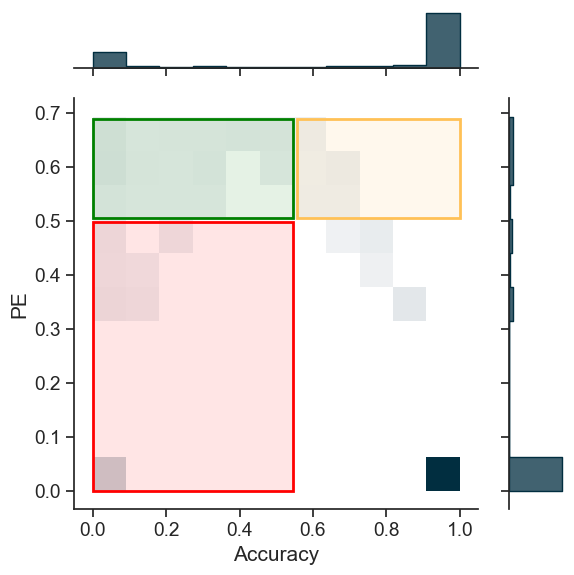

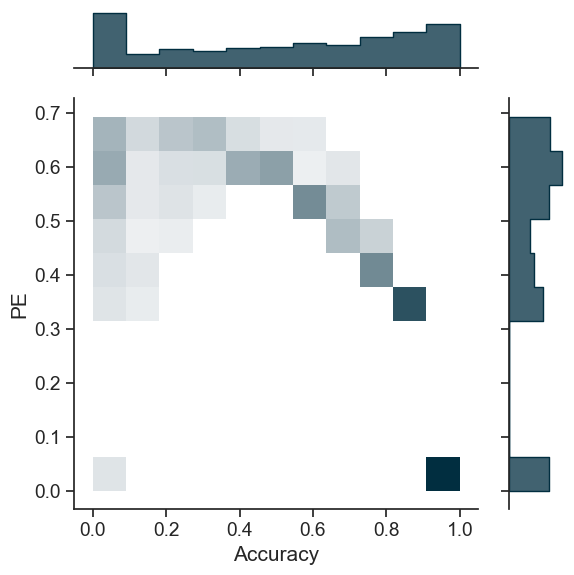

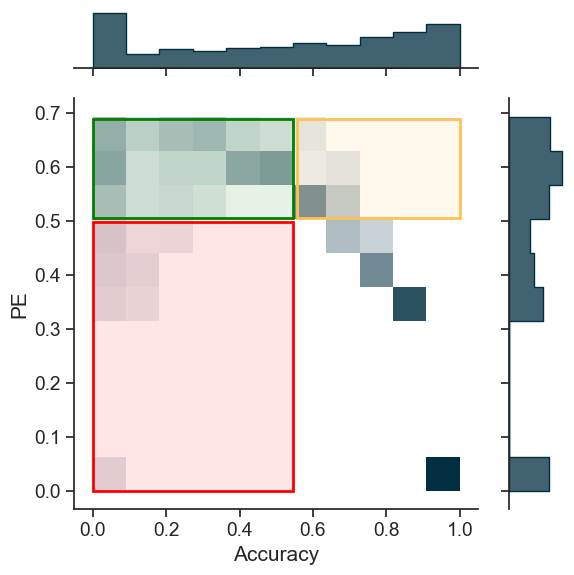

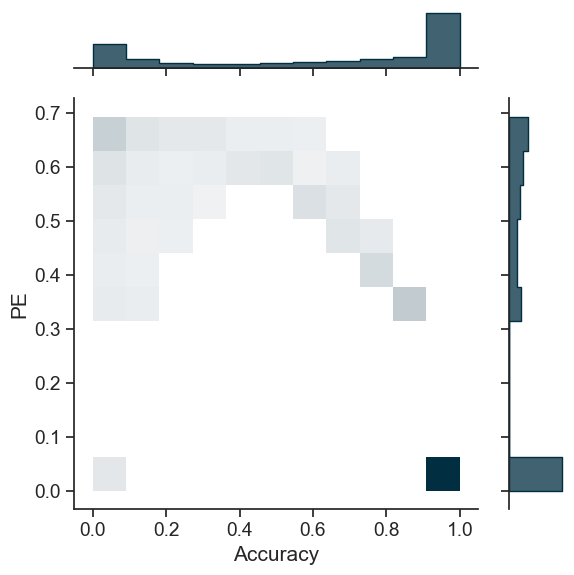

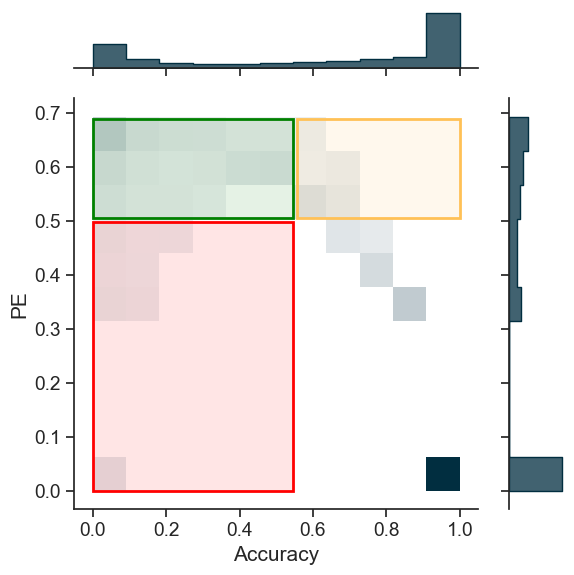

In [30]:
sns.set_theme(style="ticks")
sns.set_context("notebook", font_scale=1.25)

for model_name in features_df:
    print(f"Model {model_name}")
    df = features_df[model_name][("Generated, MaxP + H", "PE")].copy()
    g = sns.JointGrid(data=df, x="correct_mean", y="PE", marginal_ticks=False)
    g.plot_joint(
        sns.histplot,
        discrete=(False, False),
        cmap="light:#012E40",
        cbar=False,
        bins=df["correct_mean"].nunique(),
        weights=df["weight"],
    )
    g.plot_marginals(
        sns.histplot,
        element="step",
        color="#012E40",
        stat="probability",
        bins=df["correct_mean"].nunique(),
        weights=df["weight"],
    )
    g.set_axis_labels("Accuracy", "PE")
    g.figure.tight_layout()
    g.figure.savefig(
        os.path.join(images_dir, f"{model_name}_entropy_accuracy_jointplot.png"),
        bbox_inches="tight",
        dpi=300,
    )

    g = sns.JointGrid(data=df, x="correct_mean", y="PE", marginal_ticks=False)
    g.plot_joint(
        sns.histplot,
        discrete=(False, False),
        cmap="light:#012E40",
        cbar=False,
        bins=df["correct_mean"].nunique(),
        weights=df["weight"],
    )
    g.plot_marginals(
        sns.histplot,
        element="step",
        color="#012E40",
        stat="probability",
        bins=df["correct_mean"].nunique(),
        weights=df["weight"],
    )
    g.set_axis_labels("Accuracy", "PE")

    ax = g.ax_joint
    palette = TrafficLight_9.mpl_colors

    # lower‐left corner at (accuracy=0.0, entropy=0.4)
    x0, y0 = 0.0, 0.4
    x_max, y_max = ax.get_xlim()[1] / 2, ax.get_ylim()[1]
    width, height = x_max - x0, y_max - y0
    rect = Rectangle(
        (6 / 11, 0.69),
        -6 / 11,
        -0.185,
        color="green",  # fill color
        fill=True,
        zorder=5,  # draw on top
        lw=2,
    )
    face_color = rect.get_facecolor()
    rect.set_facecolor((*face_color[:3], 0.1))  # lower alpha for fill
    rect.set_edgecolor((*face_color[:3], 1.0))  # full alpha for edge
    ax.add_patch(rect)

    # lower‐left corner at (accuracy=0.0, entropy=0.0)
    x0, y0 = 0.0, 0.0
    x_max, y_max = ax.get_xlim()[1] / 2, 0.4 - 0.005
    width, height = x_max - x0, y_max - y0
    rect = Rectangle(
        (6 / 11, 0.499),
        -6 / 11,
        -0.499,
        color="red",  # fill color
        fill=True,
        zorder=5,  # draw on top
        lw=2,
    )
    face_color = rect.get_facecolor()
    rect.set_facecolor((*face_color[:3], 0.1))  # lower alpha for fill
    rect.set_edgecolor((*face_color[:3], 1.0))  # full alpha for edge
    ax.add_patch(rect)

    # lower‐left corner at (accuracy=0.5, entropy=0.4)
    x0, y0 = ax.get_xlim()[1] / 2 + 0.005, 0.4
    x_max, y_max = ax.get_xlim()[1] - 0.005, ax.get_ylim()[1]
    width, height = x_max - x0, y_max - y0
    rect = Rectangle(
        (11 / 11, 0.69),
        -5 / 11 + 0.01,
        -0.185,
        color=palette[4],  # fill color
        fill=True,
        zorder=5,  # draw on top
        lw=2,
    )
    face_color = rect.get_facecolor()
    rect.set_facecolor((*face_color[:3], 0.1))  # lower alpha for fill
    rect.set_edgecolor((*face_color[:3], 1.0))  # full alpha for edge
    ax.add_patch(rect)

    g.figure.tight_layout()
    g.figure.savefig(
        os.path.join(images_dir, f"{model_name}_entropy_accuracy_jointplot_rects.png"),
        bbox_inches="tight",
        dpi=300,
    )

### Temperature plots

In [14]:
models = ["gemma2-9b", "gemma2-2b", "tablellama"]
model_map = {
    "gemma2-9b": "Gemma-2-9B-it",
    "gemma2-2b": "Gemma-2-2B-it",
    "tablellama": "TableLlama",
}
temp_dir = "./temperature"

In [15]:
model_colors = {
    "Gemma-2-2B-it": (0.4980392156862745, 0.23529411764705882, 0.5529411764705883),
    "Gemma-2-2B-it Avg. Accuracy": (
        0.4980392156862745,
        0.23529411764705882,
        0.5529411764705883,
    ),
    "Gemma-2-9B-it": (0.06666666666666667, 0.6470588235294118, 0.4745098039215686),
    "Gemma-2-9B-it Avg. Accuracy": (
        0.06666666666666667,
        0.6470588235294118,
        0.4745098039215686,
    ),
    "TableLlama": (0.9058823529411765, 0.24705882352941178, 0.4549019607843137),
    "TableLlama Avg. Accuracy": (
        0.9058823529411765,
        0.24705882352941178,
        0.4549019607843137,
    ),
}

In [16]:
temp_df = {model_map[m]: {} for m in models}
for model in models:
    for file in os.listdir(os.path.join(temp_dir, model)):
        if "aggregated." in file:
            temperature = float(
                file.rsplit("_", maxsplit=1)[1].rsplit(".", maxsplit=1)[0]
            )
        else:
            continue
        df = pd.read_pickle(os.path.join(temp_dir, model, file))
        df = df.drop(
            columns=[
                "answer_clean",
                "cand_clean",
                "regex_match_clean",
                "regex_match_freqs",
                "regex_match_entropy",
                "regex_match_entropy_norm",
                "num_answers",
                "answers_entropy",
            ]
        )
        df = df.explode("answers_freqs")
        df = df.rename(
            columns={
                "answers_freqs": "count",
                "correct": "correct_mean",
                "answers_entropy_norm": "PE",
            }
        )
        df["count"] = df["count"].astype(float)
        df["PE"] = df["PE"].astype(float)
        df["correct_mean"] = df["correct_mean"].astype(float)
        df["correct_mean_thr"] = df["correct_mean"] >= 0.5
        df["weight"] = df["count"] / 10
        temp_df[model_map[model]][f"{temperature:.1f}"] = df
for model in temp_df:
    temp_df[model] = dict(
        sorted(temp_df[model].items(), key=lambda item: float(item[0]))
    )

In [17]:
temp_df["TableLlama"]["1.0"]

pid  count        PE  correct_mean  correct_mean_thr  weight
0      13   10.0  0.000000           1.0              True     1.0
1      14    3.0  0.566541           0.6              True     0.3
1      14    6.0  0.566541           0.6              True     0.6
1      14    1.0  0.566541           0.6              True     0.1
2      17    5.0  0.585391           0.1             False     0.5
..    ...    ...       ...           ...               ...     ...
205  1779    5.0  0.693147           0.5              True     0.5
205  1779    5.0  0.693147           0.5              True     0.5
206  1786   10.0  0.000000           1.0              True     1.0
207  1798    2.0  0.500402           0.8              True     0.2
207  1798    8.0  0.500402           0.8              True     0.8

[342 rows x 6 columns]

In [18]:
def prepare_pid_stats(
    df,
    pid_col="pid",
    weight_col="weight",
    target_col="Entropy",
    pred_col="pred_ent",
):
    """
    From the raw runs df, build a dict mapping each pid to:
      - N: number of runs
      - p: normalized weight vector (sum=1)
      - x_pred, x_true, x_acc: NumPy arrays of pred_ent, Entropy, correct_mean
    """
    pid_groups = {}
    for pid, g in df.groupby(pid_col):
        p = g[weight_col].to_numpy()
        N = len(p)
        pid_groups[pid] = {
            "N": N,
            "p": p,
            "x_pred": (
                1 - g[pred_col].to_numpy()
                if "correct_mean" in pred_col
                else g[pred_col].to_numpy()
            ),
            "x_true": (
                1 - g[target_col].to_numpy()
                if "correct_mean" in target_col
                else g[target_col].to_numpy()
            ),
            "x_acc": g["correct_mean"].to_numpy(),
        }
    return pid_groups


def summarize(curves):
    return (
        curves.mean(axis=0),
        np.percentile(curves, 2.5, axis=0),
        np.percentile(curves, 97.5, axis=0),
    )


def bootstrap_two_level_with_oracle_fraction(
    pid_groups: dict,
    n_prompts: int,
    n_bootstraps: int = 1000,
    n_bootstrap_samples: int = 10,
    sort_by: str = "pred",  # "pred" or "true"
    n_fractions: int = 100,  # granularity of oracle coverage curve
):
    """
    For each oracle fraction ∈ [0,1], compute the hybrid accuracy where:
        - top-frac prompts (most uncertain) are corrected (accuracy=1)
        - remaining prompts use model accuracy
    Returns:
        - oracle_fracs: array of length n_fractions
        - mean, lower, upper bounds: each of shape (n_fractions,)
    """
    pid_list = list(pid_groups.keys())
    oracle_fracs = np.linspace(0, 1, n_fractions)
    prompts_accuracies = np.zeros((n_bootstraps, n_prompts))
    ranked_accuracies = np.zeros((n_bootstraps, n_fractions))

    for b in range(n_bootstraps):
        sampled = np.random.choice(pid_list, size=n_prompts, replace=True)
        means_target = np.empty(n_prompts)
        means_acc = np.empty(n_prompts)

        # Sample accuracy and sorting values
        for i, pid in enumerate(sampled):
            rec = pid_groups[pid]
            c = np.random.multinomial(n_bootstrap_samples, rec["p"])
            means_target[i] = np.dot(c, rec[f"x_{sort_by}"]) / n_bootstrap_samples
            means_acc[i] = np.dot(c, rec["x_acc"]) / n_bootstrap_samples

        # Save prompts accuracies
        prompts_accuracies[b] = means_acc

        # Sort prompts by descending predicted uncertainty
        order = np.argsort(-means_target)
        sorted_acc = means_acc[order]

        # For each oracle fraction, compute hybrid accuracy
        for j, frac in enumerate(oracle_fracs):
            n_oracle = int(frac * n_prompts)
            oracle_acc = np.ones(n_oracle)
            model_acc = sorted_acc[n_oracle:]
            hybrid_acc = np.concatenate([oracle_acc, model_acc])
            ranked_accuracies[b, j] = hybrid_acc.mean()

    return oracle_fracs * 100, ranked_accuracies, prompts_accuracies

In [19]:
per_temp_aucs = {}
per_temp_accu =  {}
n_bootstraps = 1000
for model_name in temp_df:
    per_temp_aucs[model_name] = {}
    per_temp_accu[model_name] = {}
    for temperature, df in temp_df[model_name].items():
        pid_groups = prepare_pid_stats(
            df,
            pid_col="pid",
            weight_col="weight",
            target_col="PE",
            pred_col="PE",
        )
        n_prompts = len(pid_groups)
        x, boot, prompts_accu = bootstrap_two_level_with_oracle_fraction(
            pid_groups, n_prompts, n_bootstraps=n_bootstraps, sort_by="true"
        )
        m, l, u = summarize(boot)
        per_temp_aucs[model_name][temperature] = simpson(y=m, x=x)
        m, l, u = summarize(prompts_accu)
        per_temp_accu[model_name][temperature] = m.mean()

In [41]:
per_temp_accu_df = pd.DataFrame(per_temp_accu).reset_index(names="temperature")
per_temp_accu_df["temperature"] = per_temp_accu_df["temperature"].astype(float)

In [42]:
per_temp_accu_df_plot = per_temp_accu_df.melt(
    id_vars="temperature", var_name="model", value_name="accuracy"
)
per_temp_accu_df_plot["model_acc"] = (
    per_temp_accu_df_plot["model"].astype(str) + " Avg. Accuracy"
)

In [43]:
per_temp_aucs_df = pd.DataFrame(per_temp_aucs).reset_index(names="temperature")
per_temp_aucs_df["temperature"] = per_temp_aucs_df["temperature"].astype(float)

In [47]:
per_temp_aucs_df_plot = per_temp_aucs_df.melt(
    id_vars="temperature", var_name="model", value_name="auc"
)
per_temp_aucs_df_plot["auc_norm"] = per_temp_aucs_df_plot.groupby(
    "model", group_keys=False
).apply(lambda x: (x["auc"] - x["auc"].min()) / (x["auc"].max() - x["auc"].min()))

per_temp_aucs_df_plot["auc_norm_smooth"] = gaussian_filter1d(
    per_temp_aucs_df_plot["auc_norm"], sigma=0.75
)

In [48]:
merge = per_temp_aucs_df_plot.merge(
    per_temp_accu_df_plot,
    on=["temperature", "model"],
    how="inner",
)
per_temp_aucs_df_plot["aucs_mul_accu"] = merge["auc_norm"] * merge["accuracy"]

In [53]:
auc_max_per_model = (
    per_temp_aucs_df_plot.groupby("model")["aucs_mul_accu"].idxmax().to_dict()
)
for model, idx in auc_max_per_model.items():
    auc_max_per_model[model] = per_temp_aucs_df_plot.loc[
        idx, ["temperature", "auc", "auc_norm", "auc_norm_smooth", "aucs_mul_accu"]
    ].to_dict()
auc_max_per_model = pd.DataFrame(auc_max_per_model).T.reset_index(names="model")
auc_max_per_model

model  temperature        auc  auc_norm  auc_norm_smooth  \
0  Gemma-2-2B-it          1.0  70.116179       1.0         0.978378   
1  Gemma-2-9B-it          1.3  88.428715       1.0         0.932220   
2     TableLlama          1.0  94.534444       1.0         0.947848   

   aucs_mul_accu  
0       0.281690  
1       0.583410  
2       0.768412

In [54]:
per_temp_accu_df_plot

temperature          model  accuracy                    model_acc
0           0.0  Gemma-2-9B-it  0.617543  Gemma-2-9B-it Avg. Accuracy
1           0.1  Gemma-2-9B-it  0.617185  Gemma-2-9B-it Avg. Accuracy
2           0.2  Gemma-2-9B-it  0.616708  Gemma-2-9B-it Avg. Accuracy
3           0.3  Gemma-2-9B-it  0.609828  Gemma-2-9B-it Avg. Accuracy
4           0.4  Gemma-2-9B-it  0.612092  Gemma-2-9B-it Avg. Accuracy
..          ...            ...       ...                          ...
58          1.6     TableLlama  0.705812     TableLlama Avg. Accuracy
59          1.7     TableLlama  0.685977     TableLlama Avg. Accuracy
60          1.8     TableLlama  0.670654     TableLlama Avg. Accuracy
61          1.9     TableLlama  0.657888     TableLlama Avg. Accuracy
62          2.0     TableLlama  0.637399     TableLlama Avg. Accuracy

[63 rows x 4 columns]

In [55]:
per_temp_aucs_df_plot

temperature          model        auc  auc_norm  auc_norm_smooth  \
0           0.0  Gemma-2-9B-it  80.756791  0.069998         0.122147   
1           0.1  Gemma-2-9B-it  82.414018  0.270889         0.255541   
2           0.2  Gemma-2-9B-it  83.491446  0.401497         0.385326   
3           0.3  Gemma-2-9B-it  84.053692  0.469653         0.474853   
4           0.4  Gemma-2-9B-it  84.878109  0.569590         0.543339   
..          ...            ...        ...       ...              ...   
58          1.6     TableLlama  92.209202  0.486435         0.494765   
59          1.7     TableLlama  91.145867  0.251581         0.293405   
60          1.8     TableLlama  90.863865  0.189297         0.164503   
61          1.9     TableLlama  90.033154  0.005821         0.048401   
62          2.0     TableLlama  90.006796  0.000000         0.004316   

    aucs_mul_accu  
0        0.043227  
1        0.167189  
2        0.247606  
3        0.286408  
4        0.348642  
..            ...  
58       0.343332  
59       0.172579  
60       0.126953  
61       0.003830  
62       0.000000  

[63 rows x 6 columns]

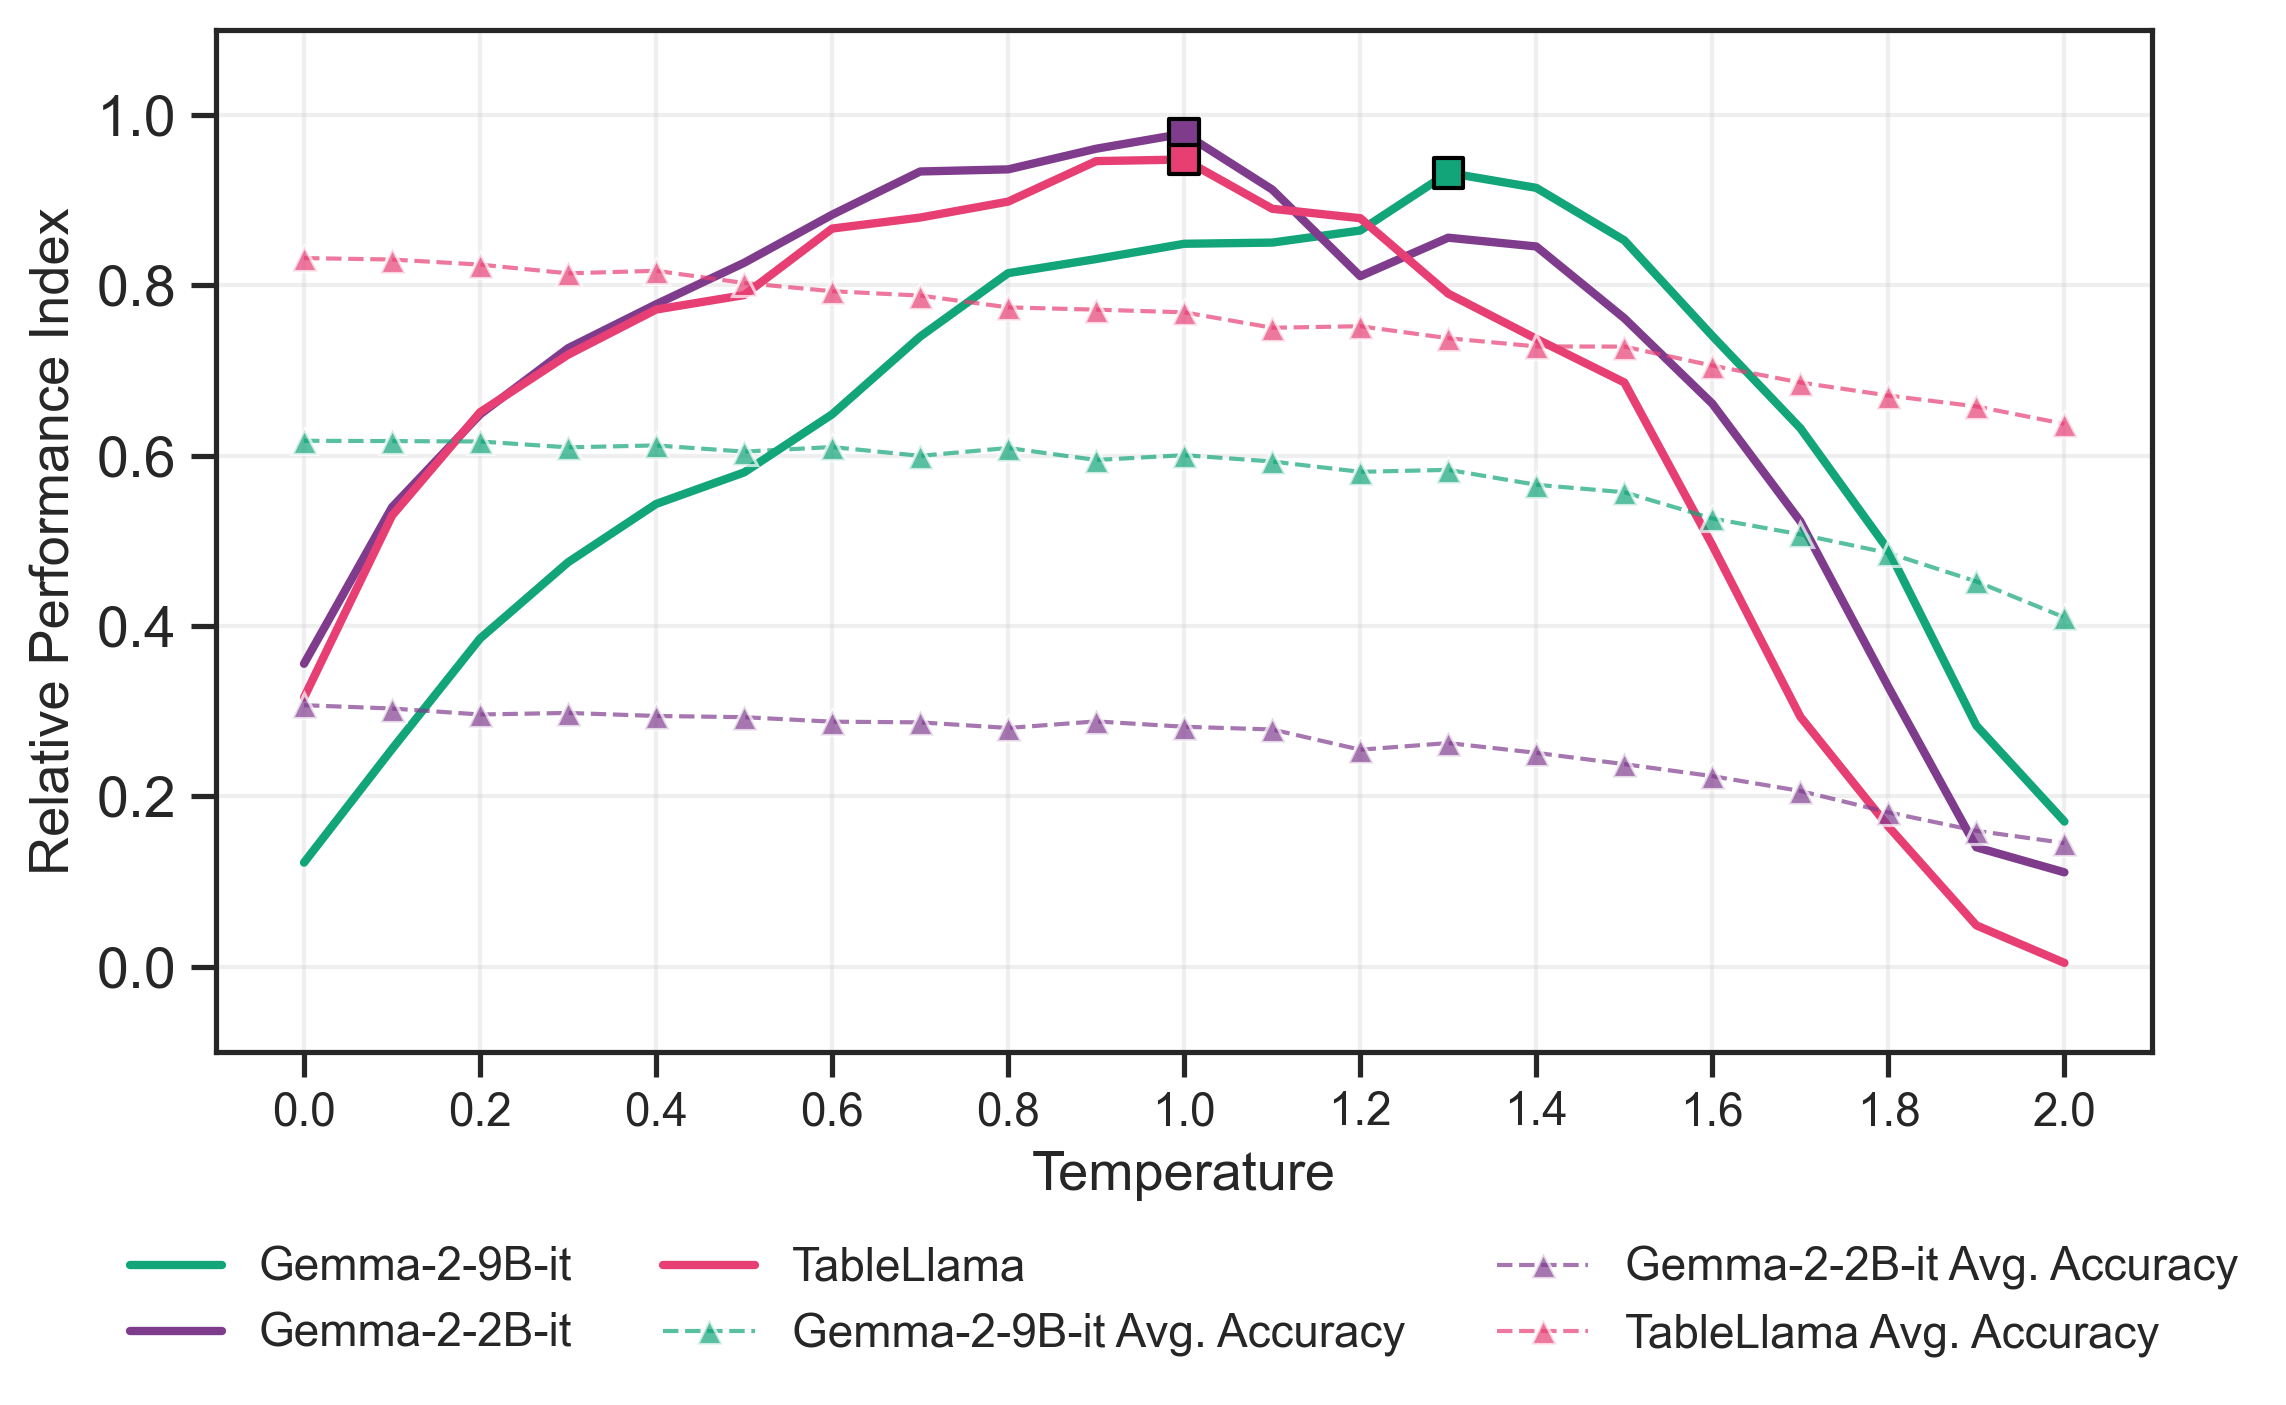

In [57]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
sns.lineplot(
    data=per_temp_aucs_df_plot,
    x="temperature",
    y="auc_norm_smooth",
    hue="model",
    palette=model_colors,
    lw=2,
    ax=ax,
    legend=True,
)
sns.lineplot(
    data=per_temp_accu_df_plot,
    x="temperature",
    y="accuracy",
    hue="model_acc",
    palette=model_colors,
    lw=1,
    ls="--",
    ax=ax,
    legend=True,
    marker="^",
    alpha=0.7,
)
sns.scatterplot(
    data=auc_max_per_model,
    x="temperature",
    y="auc_norm_smooth",
    hue="model",
    palette=model_colors,
    s=50,
    ax=ax,
    legend=False,
    marker="s",
    zorder=7,
    edgecolor="black",
    linewidth=1,
)
ax.set_xlabel("Temperature", fontsize=13)
ax.set_ylabel("Relative Performance Index", fontsize=13)
ax.set_xticks(
    np.arange(0, 2.1, 0.2),
    labels=[f"{x:.1f}" for x in np.arange(0, 2.1, 0.2)],
    fontsize=11,
)
ax.legend(fontsize=11, title="", ncol=3, frameon=False)
sns.move_legend(
    ax,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    fontsize=11,
)
ax.set_ylim(-0.1, 1.1)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(
    os.path.join(images_dir, "temperature_auc.png"),
    bbox_inches="tight",
    dpi=300,
)